# Sentiment analysis


This notebook runs the following models for sentiment analysis and show the results in terms of performance metrics:
* VADER (Valence Aware Dictionary for Sentiment Reasoning)
* TextBlob
* BERT (Bidirectional Encoder Representations from Transformers)
* XGBoost

In [4]:
# run this if you run into "ModuleNotFoundError: No module named 'src'"
import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../models')

In [2]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# importing modules
import transformations as c
from sklearn.model_selection import train_test_split
from sentiment_analysis.train.train_vader import train_vader
from sentiment_analysis.train.train_textblob import train_textblob

from sentiment_analysis.train.train_bert import *
from sentiment_analysis.train.train_xgboost import train_xgboost

from train_sentimentanalysis import *
from sentiment_analysis.train.evaluator import *

[nltk_data] Downloading package punkt to /Users/sophied/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophied/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sophied/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/sophied/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/Caskroom/miniconda/base/envs/dsa4263/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# loading data
current_path = os.getcwd()
root_path = os.path.dirname(current_path)
df = pd.read_csv(root_path + '/data/reviews.csv', encoding='unicode_escape')

In [4]:
# add labels
df['Sentiment_num'] = df.Sentiment.map({"positive": 1, "negative": 0})

In [5]:
# split train and test data
X = df["Text"].to_list()
y = df['Sentiment_num'].to_list()
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=4263
    )

## VADER & TextBlob

VADER and Textblob are rule-based models where there are predefined rules and scores to help to calculate the polarity of a sentence. The polarity score is normalised to lie between (-1 to 1) where -1 identifies the most negative words while 1 identifies the most positive words. 

* For VADER, a polarity of >= 0.05 will be tagged as positive sentiment, <= -0.05 will be tagged as negative sentiment and any other value will be neutral sentiment
* For VADER, a polarity of >= 0 will be tagged as positive sentiment, <= 0 will be tagged as negative sentiment and any other value will be neutral sentiment

However, in our dataset, there is no neutral sentiment and all sentences have to be tagged as either positive or negative. Hence an appropriate threshold had to be found to determine whether the sentence is positive or negative.

The steps taken to find the threshold are as follows:
1. offset the polarity score (in float) from (-1,1) to (0,1)
2. convert offset float score in (0,1) to integer value in range (1,20)
3. simulate probabilities of each class based on a normal distribution
4. return the index of the highest probability
5. if the index <= 10, tag as negative sentiment, else tag as positive sentiment

In [7]:
# run vader and textblob
vader = train_vader(X_test)
textblob = train_textblob(X_test)

## BERT

BERT model is fine-tuned and trained using the Hugging Face Transformers library. The pre-traned model of choice is __[bert-base-uncased](https://huggingface.co/bert-base-uncased)__. 

>BERT is a transformers model pretrained on a large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labeling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts.

The original __[BERT paper](https://arxiv.org/abs/1810.04805)__ stated a range of values for batch size, learning rate and number of epochs that worked well across all tasks tested on. The hyperparameter grid for this model was based on the recommended values (subset of the values).

The model was tuned for the following parameters with 1-fold grid search:
* learning_rate: 3e-5, 5e-5
* num_train_epochs: 2, 4

Learning rate of 5e-5 with 2 training epochs achieved the highest accuracy.

This section is commented out as the tuning and training take longer to run and the best model from tuning has already been saved in '.../models/bert-tuned'.

In [ ]:
# fine tune pre-trained bert model
#best_trial = tune_bert(X_train, X_test, y_train, y_test, use_mps = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

== Status ==
Current time: 2023-04-08 14:39:40 (running for 00:00:00.05)
Memory usage on this node: 4.6/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

(_objective pid=2301) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
(_objective pid=2301) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2301) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2301) Some we

== Status ==
Current time: 2023-04-08 14:39:48 (running for 00:00:07.77)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  0%|          | 2/1090 [00:21<2:40:24,  8.85s/it]


== Status ==
Current time: 2023-04-08 14:40:08 (running for 00:00:27.79)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  1%|          | 10/1090 [00:26<15:57,  1.13it/s]


== Status ==
Current time: 2023-04-08 14:40:13 (running for 00:00:32.79)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  2%|▏         | 17/1090 [00:30<11:51,  1.51it/s]


== Status ==
Current time: 2023-04-08 14:40:18 (running for 00:00:37.80)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  2%|▏         | 25/1090 [00:35<11:25,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:40:23 (running for 00:00:42.80)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  3%|▎         | 33/1090 [00:41<11:22,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:40:28 (running for 00:00:47.80)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  4%|▍         | 41/1090 [00:46<11:20,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:40:33 (running for 00:00:52.81)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  4%|▍         | 48/1090 [00:50<11:16,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:40:38 (running for 00:00:57.81)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  5%|▌         | 56/1090 [00:56<11:12,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:40:43 (running for 00:01:02.81)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  6%|▌         | 64/1090 [01:01<11:09,  1.53it/s]


== Status ==
Current time: 2023-04-08 14:40:48 (running for 00:01:07.82)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  7%|▋         | 71/1090 [01:05<11:06,  1.53it/s]


== Status ==
Current time: 2023-04-08 14:40:53 (running for 00:01:12.82)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  7%|▋         | 79/1090 [01:11<11:33,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:40:58 (running for 00:01:17.82)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  8%|▊         | 86/1090 [01:15<11:03,  1.51it/s]


== Status ==
Current time: 2023-04-08 14:41:03 (running for 00:01:22.82)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  9%|▊         | 94/1090 [01:21<10:56,  1.52it/s]


== Status ==
Current time: 2023-04-08 14:41:08 (running for 00:01:27.83)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

  9%|▉         | 101/1090 [01:25<10:55,  1.51it/s]


== Status ==
Current time: 2023-04-08 14:41:13 (running for 00:01:32.83)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 10%|█         | 109/1090 [01:31<10:52,  1.50it/s]


== Status ==
Current time: 2023-04-08 14:41:18 (running for 00:01:37.84)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 11%|█         | 116/1090 [01:35<10:48,  1.50it/s]


== Status ==
Current time: 2023-04-08 14:41:23 (running for 00:01:42.84)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 11%|█▏        | 124/1090 [01:41<10:46,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:41:28 (running for 00:01:47.84)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 12%|█▏        | 131/1090 [01:45<10:41,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:41:33 (running for 00:01:52.85)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 13%|█▎        | 139/1090 [01:51<10:37,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:41:38 (running for 00:01:57.85)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 13%|█▎        | 146/1090 [01:55<10:32,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:41:43 (running for 00:02:02.85)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 14%|█▍        | 154/1090 [02:01<10:26,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:41:48 (running for 00:02:07.86)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 15%|█▍        | 161/1090 [02:05<10:25,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:41:53 (running for 00:02:12.86)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 16%|█▌        | 169/1090 [02:11<10:17,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:41:58 (running for 00:02:17.86)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 16%|█▌        | 176/1090 [02:15<10:11,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:42:03 (running for 00:02:22.87)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 17%|█▋        | 184/1090 [02:21<10:13,  1.48it/s]


== Status ==
Current time: 2023-04-08 14:42:08 (running for 00:02:27.87)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 18%|█▊        | 191/1090 [02:26<10:08,  1.48it/s]


== Status ==
Current time: 2023-04-08 14:42:13 (running for 00:02:32.87)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 18%|█▊        | 198/1090 [02:30<10:06,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:42:18 (running for 00:02:37.88)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 19%|█▉        | 206/1090 [02:36<09:58,  1.48it/s]


== Status ==
Current time: 2023-04-08 14:42:23 (running for 00:02:42.88)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 20%|█▉        | 213/1090 [02:41<09:56,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:42:28 (running for 00:02:47.88)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 20%|██        | 220/1090 [02:45<09:52,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:42:33 (running for 00:02:52.89)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 21%|██        | 228/1090 [02:51<09:45,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:42:38 (running for 00:02:57.89)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 22%|██▏       | 235/1090 [02:56<09:38,  1.48it/s]


== Status ==
Current time: 2023-04-08 14:42:43 (running for 00:03:02.89)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 22%|██▏       | 243/1090 [03:01<09:36,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:42:48 (running for 00:03:07.90)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 23%|██▎       | 250/1090 [03:06<09:33,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:42:53 (running for 00:03:12.90)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 24%|██▎       | 257/1090 [03:11<09:27,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:42:58 (running for 00:03:17.90)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 24%|██▍       | 264/1090 [03:15<09:23,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:03 (running for 00:03:22.90)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 25%|██▍       | 272/1090 [03:21<09:19,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:08 (running for 00:03:27.91)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 26%|██▌       | 279/1090 [03:26<09:13,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:43:13 (running for 00:03:32.91)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 26%|██▌       | 286/1090 [03:30<09:10,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:18 (running for 00:03:37.91)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 27%|██▋       | 294/1090 [03:36<09:04,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:23 (running for 00:03:42.92)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 28%|██▊       | 301/1090 [03:41<08:59,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:28 (running for 00:03:47.92)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 28%|██▊       | 308/1090 [03:45<08:55,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:33 (running for 00:03:52.92)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 29%|██▉       | 316/1090 [03:51<08:49,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:38 (running for 00:03:57.93)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 30%|██▉       | 323/1090 [03:56<08:45,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:43 (running for 00:04:02.93)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 30%|███       | 330/1090 [04:00<08:39,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:43:48 (running for 00:04:07.93)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 31%|███       | 338/1090 [04:06<08:38,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:43:53 (running for 00:04:12.94)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 32%|███▏      | 345/1090 [04:11<08:32,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:43:58 (running for 00:04:17.94)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 32%|███▏      | 352/1090 [04:16<08:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:03 (running for 00:04:22.94)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 33%|███▎      | 359/1090 [04:20<08:23,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:08 (running for 00:04:27.95)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 34%|███▎      | 367/1090 [04:26<08:18,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:13 (running for 00:04:32.95)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 34%|███▍      | 374/1090 [04:31<08:13,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:18 (running for 00:04:37.95)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 35%|███▍      | 381/1090 [04:36<08:08,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:23 (running for 00:04:42.96)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 36%|███▌      | 388/1090 [04:40<08:03,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:28 (running for 00:04:47.96)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 36%|███▋      | 396/1090 [04:46<07:58,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:33 (running for 00:04:52.96)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 37%|███▋      | 403/1090 [04:51<07:55,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:38 (running for 00:04:57.97)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 38%|███▊      | 410/1090 [04:56<07:49,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:43 (running for 00:05:02.97)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 38%|███▊      | 417/1090 [05:00<07:43,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:48 (running for 00:05:07.97)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 39%|███▉      | 425/1090 [05:06<07:38,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:53 (running for 00:05:12.98)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 40%|███▉      | 432/1090 [05:11<07:33,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:44:58 (running for 00:05:17.98)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 40%|████      | 439/1090 [05:16<07:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:45:03 (running for 00:05:22.98)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 41%|████      | 447/1090 [05:21<07:24,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:45:08 (running for 00:05:27.99)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 42%|████▏     | 454/1090 [05:26<07:18,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:45:13 (running for 00:05:32.99)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 42%|████▏     | 461/1090 [05:31<07:16,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:45:18 (running for 00:05:37.99)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 43%|████▎     | 468/1090 [05:36<07:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:45:23 (running for 00:05:43.00)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 44%|████▎     | 475/1090 [05:40<07:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:45:28 (running for 00:05:48.00)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 44%|████▍     | 483/1090 [05:46<07:00,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:45:33 (running for 00:05:53.00)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 45%|████▍     | 490/1090 [05:51<06:56,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:45:38 (running for 00:05:58.01)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 46%|████▌     | 497/1090 [05:56<06:51,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:45:43 (running for 00:06:03.01)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 46%|████▌     | 499/1090 [05:57<06:51,  1.44it/s]


(_objective pid=2301) {'loss': 0.2563, 'learning_rate': 1.6238532110091743e-05, 'epoch': 0.92}


 46%|████▌     | 502/1090 [06:01<09:46,  1.00it/s]


== Status ==
Current time: 2023-04-08 14:45:48 (running for 00:06:08.01)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 47%|████▋     | 510/1090 [06:06<06:52,  1.41it/s]


== Status ==
Current time: 2023-04-08 14:45:53 (running for 00:06:13.02)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 47%|████▋     | 517/1090 [06:11<06:39,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:45:58 (running for 00:06:18.02)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 48%|████▊     | 524/1090 [06:16<06:34,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:46:03 (running for 00:06:23.02)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 49%|████▊     | 531/1090 [06:21<06:28,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:46:08 (running for 00:06:28.03)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 49%|████▉     | 538/1090 [06:26<06:22,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:46:13 (running for 00:06:33.03)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 50%|█████     | 546/1090 [06:31<05:34,  1.63it/s]


== Status ==
Current time: 2023-04-08 14:46:18 (running for 00:06:38.03)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 51%|█████     | 553/1090 [06:36<06:10,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:46:23 (running for 00:06:43.04)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 51%|█████▏    | 560/1090 [06:40<06:08,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:46:28 (running for 00:06:48.04)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 52%|█████▏    | 568/1090 [06:46<06:04,  1.43it/s]


== Status ==
Current time: 2023-04-08 14:46:33 (running for 00:06:53.04)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 53%|█████▎    | 575/1090 [06:51<06:01,  1.42it/s]


== Status ==
Current time: 2023-04-08 14:46:38 (running for 00:06:58.04)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 53%|█████▎    | 582/1090 [06:56<05:51,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:46:43 (running for 00:07:03.05)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 54%|█████▍    | 589/1090 [07:01<05:46,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:46:48 (running for 00:07:08.05)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 55%|█████▍    | 596/1090 [07:05<05:41,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:46:53 (running for 00:07:13.05)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 55%|█████▌    | 604/1090 [07:11<05:34,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:46:58 (running for 00:07:18.06)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 56%|█████▌    | 611/1090 [07:16<05:29,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:03 (running for 00:07:23.06)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 57%|█████▋    | 618/1090 [07:21<05:25,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:08 (running for 00:07:28.06)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 57%|█████▋    | 626/1090 [07:26<05:19,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:13 (running for 00:07:33.07)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 58%|█████▊    | 633/1090 [07:31<05:14,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:18 (running for 00:07:38.07)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 59%|█████▊    | 640/1090 [07:36<05:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:23 (running for 00:07:43.07)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 59%|█████▉    | 647/1090 [07:41<05:06,  1.44it/s]


== Status ==
Current time: 2023-04-08 14:47:28 (running for 00:07:48.08)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 60%|██████    | 654/1090 [07:45<05:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:33 (running for 00:07:53.08)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 61%|██████    | 662/1090 [07:51<04:55,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:38 (running for 00:07:58.08)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 61%|██████▏   | 669/1090 [07:56<04:50,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:43 (running for 00:08:03.09)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 62%|██████▏   | 676/1090 [08:01<04:46,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:48 (running for 00:08:08.09)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 63%|██████▎   | 684/1090 [08:06<04:40,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:47:53 (running for 00:08:13.09)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 63%|██████▎   | 691/1090 [08:11<04:47,  1.39it/s]


== Status ==
Current time: 2023-04-08 14:47:58 (running for 00:08:18.10)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 64%|██████▍   | 698/1090 [08:16<04:31,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:48:03 (running for 00:08:23.10)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 65%|██████▍   | 705/1090 [08:21<04:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:48:08 (running for 00:08:28.10)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 65%|██████▌   | 712/1090 [08:26<04:21,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:48:13 (running for 00:08:33.11)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 66%|██████▌   | 720/1090 [08:31<04:15,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:48:18 (running for 00:08:38.11)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 67%|██████▋   | 727/1090 [08:36<04:07,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:48:24 (running for 00:08:43.11)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 67%|██████▋   | 734/1090 [08:41<03:58,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:48:29 (running for 00:08:48.12)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 68%|██████▊   | 742/1090 [08:46<03:52,  1.50it/s]


== Status ==
Current time: 2023-04-08 14:48:34 (running for 00:08:53.12)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 69%|██████▉   | 750/1090 [08:51<03:43,  1.52it/s]


== Status ==
Current time: 2023-04-08 14:48:39 (running for 00:08:58.12)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 69%|██████▉   | 757/1090 [08:56<03:37,  1.53it/s]


== Status ==
Current time: 2023-04-08 14:48:44 (running for 00:09:03.13)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 70%|███████   | 765/1090 [09:01<03:31,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:48:49 (running for 00:09:08.13)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 71%|███████   | 772/1090 [09:06<03:26,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:48:54 (running for 00:09:13.13)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 72%|███████▏  | 780/1090 [09:11<03:19,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:48:59 (running for 00:09:18.13)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 72%|███████▏  | 788/1090 [09:16<03:13,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:49:04 (running for 00:09:23.14)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 73%|███████▎  | 796/1090 [09:21<03:07,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:49:09 (running for 00:09:28.14)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 74%|███████▍  | 804/1090 [09:26<03:02,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:49:14 (running for 00:09:33.15)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 74%|███████▍  | 812/1090 [09:31<02:57,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:49:19 (running for 00:09:38.15)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 75%|███████▌  | 820/1090 [09:36<02:51,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:49:24 (running for 00:09:43.15)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 76%|███████▌  | 827/1090 [09:41<02:47,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:49:29 (running for 00:09:48.16)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 77%|███████▋  | 835/1090 [09:46<02:41,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:49:34 (running for 00:09:53.16)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 77%|███████▋  | 843/1090 [09:51<02:37,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:49:39 (running for 00:09:58.16)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 78%|███████▊  | 851/1090 [09:56<02:31,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:49:44 (running for 00:10:03.17)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 79%|███████▉  | 859/1090 [10:01<02:25,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:49:49 (running for 00:10:08.17)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 80%|███████▉  | 867/1090 [10:06<02:21,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:49:54 (running for 00:10:13.17)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 80%|████████  | 875/1090 [10:11<02:16,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:49:59 (running for 00:10:18.17)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 81%|████████  | 883/1090 [10:16<02:11,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:04 (running for 00:10:23.18)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 82%|████████▏ | 891/1090 [10:21<02:05,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:09 (running for 00:10:28.18)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 82%|████████▏ | 898/1090 [10:26<02:01,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:14 (running for 00:10:33.18)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 83%|████████▎ | 906/1090 [10:31<01:56,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:19 (running for 00:10:38.19)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 84%|████████▍ | 914/1090 [10:36<01:51,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:24 (running for 00:10:43.19)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 85%|████████▍ | 922/1090 [10:41<01:46,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:50:29 (running for 00:10:48.19)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 85%|████████▌ | 930/1090 [10:46<01:41,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:50:34 (running for 00:10:53.20)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 86%|████████▌ | 938/1090 [10:51<01:36,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:39 (running for 00:10:58.20)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 87%|████████▋ | 946/1090 [10:56<01:31,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:50:44 (running for 00:11:03.21)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 88%|████████▊ | 954/1090 [11:01<01:26,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:49 (running for 00:11:08.21)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 88%|████████▊ | 962/1090 [11:06<01:21,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:54 (running for 00:11:13.21)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 89%|████████▉ | 969/1090 [11:11<01:16,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:50:59 (running for 00:11:18.22)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 90%|████████▉ | 977/1090 [11:16<01:11,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:51:04 (running for 00:11:23.22)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 90%|█████████ | 985/1090 [11:21<01:06,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:51:09 (running for 00:11:28.22)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 91%|█████████ | 993/1090 [11:26<01:01,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:51:14 (running for 00:11:33.23)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 92%|█████████▏| 999/1090 [11:30<00:57,  1.57it/s]


(_objective pid=2301) {'loss': 0.0902, 'learning_rate': 2.4770642201834866e-06, 'epoch': 1.83}


 92%|█████████▏| 1000/1090 [11:30<00:57,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:51:19 (running for 00:11:38.23)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 92%|█████████▏| 1007/1090 [11:36<00:56,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:51:24 (running for 00:11:43.23)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 93%|█████████▎| 1015/1090 [11:41<00:47,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:51:29 (running for 00:11:48.24)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 94%|█████████▍| 1022/1090 [11:46<00:42,  1.59it/s]


== Status ==
Current time: 2023-04-08 14:51:34 (running for 00:11:53.24)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 94%|█████████▍| 1030/1090 [11:51<00:37,  1.59it/s]


== Status ==
Current time: 2023-04-08 14:51:39 (running for 00:11:58.24)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 95%|█████████▌| 1038/1090 [11:56<00:32,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:51:44 (running for 00:12:03.25)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 96%|█████████▌| 1046/1090 [12:01<00:27,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:51:49 (running for 00:12:08.25)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 97%|█████████▋| 1054/1090 [12:06<00:22,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:51:54 (running for 00:12:13.25)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 97%|█████████▋| 1062/1090 [12:11<00:17,  1.59it/s]


== Status ==
Current time: 2023-04-08 14:51:59 (running for 00:12:18.25)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 98%|█████████▊| 1070/1090 [12:16<00:12,  1.59it/s]


== Status ==
Current time: 2023-04-08 14:52:04 (running for 00:12:23.26)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 99%|█████████▉| 1078/1090 [12:21<00:07,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:52:09 (running for 00:12:28.26)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

100%|█████████▉| 1086/1090 [12:26<00:02,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:52:14 (running for 00:12:33.27)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

100%|█████████▉| 1089/1090 [12:28<00:00,  1.58it/s]


(_objective pid=2301) {'train_runtime': 748.7941, 'train_samples_per_second': 11.632, 'train_steps_per_second': 1.456, 'train_loss': 0.1635762380897452, 'epoch': 2.0}


  9%|▉         | 13/137 [00:02<00:26,  4.75it/s]


== Status ==
Current time: 2023-04-08 14:52:19 (running for 00:12:38.27)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 27%|██▋       | 37/137 [00:07<00:21,  4.71it/s]


== Status ==
Current time: 2023-04-08 14:52:24 (running for 00:12:43.27)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 45%|████▍     | 61/137 [00:12<00:16,  4.71it/s]


== Status ==
Current time: 2023-04-08 14:52:29 (running for 00:12:48.27)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 61%|██████▏   | 84/137 [00:17<00:11,  4.71it/s]


== Status ==
Current time: 2023-04-08 14:52:34 (running for 00:12:53.28)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 79%|███████▉  | 108/137 [00:22<00:06,  4.72it/s]


== Status ==
Current time: 2023-04-08 14:52:39 (running for 00:12:58.28)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 96%|█████████▋| 132/137 [00:27<00:01,  4.72it/s]


== Status ==
Current time: 2023-04-08 14:52:44 (running for 00:13:03.28)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (3 PENDING, 1 RUNNING)
+------------------------+----------+--------------------+-----------------+--------------------+
| Trial name             | status   | loc                |   learning_rate |   num_train_epochs |
|------------------------+----------+--------------------+-----------------+--------------------|
| _objective_31f39_00000 | RUNNING  | 172.16.172.38:2301 |           3e-05 |                  2 |
| _objective_31f39_00001 | PENDING  |                    |           5e-05 |                  2 |
| _objective_31f39_00002 | PENDING  |                    |           3e-05 |                  4 |
| _objective_31f39_00003 | PENDING  |                    |    

 99%|█████████▊| 135/137 [00:28<00:00,  4.72it/s]


Trial name,date,done,episodes_total,epoch,eval_accuracy,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,experiment_id,hostname,iterations_since_restore,node_ip,objective,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
_objective_31f39_00000,2023-04-08_14-52-45,True,,2,0.953168,0.206239,28.9839,37.573,4.727,b07d653016a94f8eb5222e33cb02a025,ip-172-16-172-38.ec2.internal,1,172.16.172.38,0.953168,2301,781.378,781.378,781.378,1680965565,0,,1,31f39_00000,0.00326657
_objective_31f39_00001,2023-04-08_15-05-19,True,,2,0.957759,0.19496,29.622,36.763,4.625,5202cbef2dc045359046b0043db99ad5,ip-172-16-172-38.ec2.internal,1,172.16.172.38,0.957759,13397,751.609,751.609,751.609,1680966319,0,,1,31f39_00001,0.00335288
_objective_31f39_00002,2023-04-08_15-31-04,True,,4,0.957759,0.289946,32.6204,33.384,4.2,8e9b52b1c63c4d018f05ed620a308e52,ip-172-16-172-38.ec2.internal,1,172.16.172.38,0.957759,24482,1541.97,1541.97,1541.97,1680967864,0,,1,31f39_00002,0.00302124
_objective_31f39_00003,2023-04-08_15-55-54,True,,4,0.953168,0.317808,29.7305,36.629,4.608,1d31ac9681d640da9fd4aea8e59551ba,ip-172-16-172-38.ec2.internal,1,172.16.172.38,0.953168,14371,1486.09,1486.09,1486.09,1680969354,0,,1,31f39_00003,0.00301337


100%|██████████| 137/137 [00:28<00:00,  4.77it/s]


== Status ==
Current time: 2023-04-08 14:52:50 (running for 00:13:09.49)
Memory usage on this node: 6.0/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

(_objective pid=13397) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
(_objective pid=13397) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=13397) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=13397) Som

== Status ==
Current time: 2023-04-08 14:52:55 (running for 00:13:14.50)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  1%|          | 12/1090 [00:07<11:22,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:00 (running for 00:13:19.50)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  2%|▏         | 20/1090 [00:13<11:17,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:05 (running for 00:13:24.51)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  3%|▎         | 28/1090 [00:18<11:11,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:10 (running for 00:13:29.51)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  3%|▎         | 36/1090 [00:23<11:07,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:15 (running for 00:13:34.51)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  4%|▍         | 44/1090 [00:28<11:01,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:20 (running for 00:13:39.52)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  5%|▍         | 52/1090 [00:33<10:56,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:25 (running for 00:13:44.52)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  6%|▌         | 60/1090 [00:38<10:52,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:30 (running for 00:13:49.52)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  6%|▌         | 68/1090 [00:43<10:50,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:53:35 (running for 00:13:54.53)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  7%|▋         | 76/1090 [00:48<10:43,  1.58it/s]


== Status ==
Current time: 2023-04-08 14:53:40 (running for 00:13:59.53)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  8%|▊         | 83/1090 [00:53<10:49,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:53:45 (running for 00:14:04.53)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  8%|▊         | 91/1090 [00:58<10:35,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:53:50 (running for 00:14:09.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

  9%|▉         | 99/1090 [01:03<10:29,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:53:55 (running for 00:14:14.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 10%|▉         | 107/1090 [01:08<10:28,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:54:00 (running for 00:14:19.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 11%|█         | 115/1090 [01:13<10:21,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:54:05 (running for 00:14:24.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 11%|█         | 122/1090 [01:17<10:15,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:54:10 (running for 00:14:29.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 12%|█▏        | 130/1090 [01:23<10:09,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:54:15 (running for 00:14:34.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 13%|█▎        | 138/1090 [01:28<10:07,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:54:20 (running for 00:14:39.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 13%|█▎        | 146/1090 [01:33<10:02,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:54:25 (running for 00:14:44.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 14%|█▍        | 154/1090 [01:38<09:58,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:54:30 (running for 00:14:49.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 15%|█▍        | 162/1090 [01:43<09:56,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:54:35 (running for 00:14:54.57)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 16%|█▌        | 170/1090 [01:48<09:47,  1.57it/s]


== Status ==
Current time: 2023-04-08 14:54:40 (running for 00:14:59.57)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 16%|█▌        | 177/1090 [01:53<09:43,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:54:45 (running for 00:15:04.58)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 17%|█▋        | 185/1090 [01:58<09:40,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:54:50 (running for 00:15:09.58)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 18%|█▊        | 193/1090 [02:03<09:35,  1.56it/s]


== Status ==
Current time: 2023-04-08 14:54:55 (running for 00:15:14.58)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 18%|█▊        | 201/1090 [02:08<09:31,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:55:00 (running for 00:15:19.59)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 19%|█▉        | 208/1090 [02:12<09:27,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:55:05 (running for 00:15:24.59)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 20%|█▉        | 216/1090 [02:18<09:23,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:55:10 (running for 00:15:29.59)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 21%|██        | 224/1090 [02:23<09:18,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:55:15 (running for 00:15:34.60)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 21%|██▏       | 232/1090 [02:28<09:14,  1.55it/s]


== Status ==
Current time: 2023-04-08 14:55:20 (running for 00:15:39.60)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 22%|██▏       | 239/1090 [02:33<09:10,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:55:25 (running for 00:15:44.60)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 23%|██▎       | 247/1090 [02:38<09:06,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:55:30 (running for 00:15:49.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 23%|██▎       | 255/1090 [02:43<09:01,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:55:35 (running for 00:15:54.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 24%|██▍       | 263/1090 [02:48<08:59,  1.53it/s]


== Status ==
Current time: 2023-04-08 14:55:40 (running for 00:15:59.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 25%|██▍       | 270/1090 [02:53<08:52,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:55:45 (running for 00:16:04.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 26%|██▌       | 278/1090 [02:58<08:48,  1.54it/s]


== Status ==
Current time: 2023-04-08 14:55:50 (running for 00:16:09.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 26%|██▌       | 286/1090 [03:03<08:44,  1.53it/s]


== Status ==
Current time: 2023-04-08 14:55:55 (running for 00:16:14.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 27%|██▋       | 293/1090 [03:08<08:41,  1.53it/s]


== Status ==
Current time: 2023-04-08 14:56:00 (running for 00:16:19.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 28%|██▊       | 301/1090 [03:13<08:38,  1.52it/s]


== Status ==
Current time: 2023-04-08 14:56:05 (running for 00:16:24.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 28%|██▊       | 308/1090 [03:18<08:34,  1.52it/s]


== Status ==
Current time: 2023-04-08 14:56:10 (running for 00:16:29.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 29%|██▉       | 316/1090 [03:23<08:31,  1.51it/s]


== Status ==
Current time: 2023-04-08 14:56:15 (running for 00:16:34.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 30%|██▉       | 324/1090 [03:28<08:27,  1.51it/s]


== Status ==
Current time: 2023-04-08 14:56:20 (running for 00:16:39.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 30%|███       | 331/1090 [03:33<08:21,  1.51it/s]


== Status ==
Current time: 2023-04-08 14:56:25 (running for 00:16:44.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 31%|███       | 339/1090 [03:38<08:20,  1.50it/s]


== Status ==
Current time: 2023-04-08 14:56:30 (running for 00:16:49.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 32%|███▏      | 346/1090 [03:43<08:19,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:56:35 (running for 00:16:54.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 32%|███▏      | 354/1090 [03:48<08:13,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:56:40 (running for 00:16:59.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 33%|███▎      | 361/1090 [03:53<08:07,  1.50it/s]


== Status ==
Current time: 2023-04-08 14:56:45 (running for 00:17:04.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 34%|███▍      | 369/1090 [03:58<08:04,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:56:50 (running for 00:17:09.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 34%|███▍      | 376/1090 [04:03<07:58,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:56:55 (running for 00:17:14.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 35%|███▌      | 384/1090 [04:08<07:54,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:57:00 (running for 00:17:19.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 36%|███▌      | 391/1090 [04:13<07:50,  1.48it/s]


== Status ==
Current time: 2023-04-08 14:57:05 (running for 00:17:24.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 37%|███▋      | 398/1090 [04:18<07:44,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:57:10 (running for 00:17:29.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 37%|███▋      | 406/1090 [04:23<07:39,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:57:15 (running for 00:17:34.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 38%|███▊      | 413/1090 [04:28<07:35,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:57:20 (running for 00:17:39.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 39%|███▊      | 421/1090 [04:33<07:31,  1.48it/s]


== Status ==
Current time: 2023-04-08 14:57:25 (running for 00:17:44.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 39%|███▉      | 428/1090 [04:38<07:24,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:57:30 (running for 00:17:49.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 40%|████      | 436/1090 [04:43<07:23,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:57:35 (running for 00:17:54.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 41%|████      | 443/1090 [04:48<07:18,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:57:40 (running for 00:17:59.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 41%|████▏     | 450/1090 [04:53<07:14,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:57:45 (running for 00:18:04.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 42%|████▏     | 458/1090 [04:58<07:08,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:57:50 (running for 00:18:09.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 43%|████▎     | 465/1090 [05:03<07:04,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:57:55 (running for 00:18:14.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 43%|████▎     | 472/1090 [05:08<07:00,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:58:00 (running for 00:18:19.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 44%|████▍     | 480/1090 [05:13<06:54,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:58:05 (running for 00:18:24.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 45%|████▍     | 487/1090 [05:18<06:49,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:58:10 (running for 00:18:29.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 45%|████▌     | 494/1090 [05:23<06:47,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:58:15 (running for 00:18:34.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 46%|████▌     | 499/1090 [05:26<06:43,  1.46it/s]


(_objective pid=13397) {'loss': 0.2881, 'learning_rate': 2.7064220183486238e-05, 'epoch': 0.92}


 46%|████▌     | 500/1090 [05:27<06:41,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:58:20 (running for 00:18:39.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 47%|████▋     | 507/1090 [05:33<07:05,  1.37it/s]


== Status ==
Current time: 2023-04-08 14:58:25 (running for 00:18:44.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 47%|████▋     | 514/1090 [05:38<06:36,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:58:30 (running for 00:18:49.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 48%|████▊     | 522/1090 [05:43<06:27,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:58:35 (running for 00:18:54.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 49%|████▊     | 529/1090 [05:48<06:25,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:58:40 (running for 00:18:59.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 49%|████▉     | 536/1090 [05:53<06:19,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:58:45 (running for 00:19:04.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 50%|████▉     | 544/1090 [05:58<06:11,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:58:50 (running for 00:19:09.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 51%|█████     | 551/1090 [06:03<06:01,  1.49it/s]


== Status ==
Current time: 2023-04-08 14:58:55 (running for 00:19:14.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 51%|█████▏    | 559/1090 [06:08<06:03,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:59:00 (running for 00:19:19.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 52%|█████▏    | 566/1090 [06:13<05:58,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:59:05 (running for 00:19:24.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 53%|█████▎    | 573/1090 [06:18<05:55,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:59:10 (running for 00:19:29.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 53%|█████▎    | 581/1090 [06:23<05:46,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:59:15 (running for 00:19:34.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 54%|█████▍    | 588/1090 [06:28<05:43,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:59:20 (running for 00:19:39.76)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 55%|█████▍    | 595/1090 [06:33<05:37,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:59:25 (running for 00:19:44.76)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 55%|█████▌    | 603/1090 [06:38<05:34,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:59:30 (running for 00:19:49.76)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 56%|█████▌    | 610/1090 [06:43<05:27,  1.47it/s]


== Status ==
Current time: 2023-04-08 14:59:35 (running for 00:19:54.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 57%|█████▋    | 617/1090 [06:48<05:24,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:59:40 (running for 00:19:59.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 57%|█████▋    | 625/1090 [06:53<05:19,  1.46it/s]


== Status ==
Current time: 2023-04-08 14:59:45 (running for 00:20:04.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 58%|█████▊    | 632/1090 [06:58<05:16,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:59:50 (running for 00:20:09.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 59%|█████▊    | 639/1090 [07:03<05:10,  1.45it/s]


== Status ==
Current time: 2023-04-08 14:59:55 (running for 00:20:14.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 59%|█████▉    | 646/1090 [07:08<05:06,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:00 (running for 00:20:19.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 60%|██████    | 654/1090 [07:13<05:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:05 (running for 00:20:24.79)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 61%|██████    | 661/1090 [07:18<04:54,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:00:10 (running for 00:20:29.79)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 61%|██████▏   | 668/1090 [07:23<04:51,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:15 (running for 00:20:34.79)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 62%|██████▏   | 675/1090 [07:28<04:47,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:20 (running for 00:20:39.80)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 63%|██████▎   | 683/1090 [07:33<04:41,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:25 (running for 00:20:44.80)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 63%|██████▎   | 690/1090 [07:38<04:36,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:30 (running for 00:20:49.80)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 64%|██████▍   | 697/1090 [07:43<04:30,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:35 (running for 00:20:54.81)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 65%|██████▍   | 704/1090 [07:48<04:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:40 (running for 00:20:59.81)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 65%|██████▌   | 712/1090 [07:53<04:20,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:45 (running for 00:21:04.81)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 66%|██████▌   | 719/1090 [07:58<04:15,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:50 (running for 00:21:09.82)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 67%|██████▋   | 726/1090 [08:03<04:10,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:00:55 (running for 00:21:14.82)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 67%|██████▋   | 733/1090 [08:08<04:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:01:00 (running for 00:21:19.82)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 68%|██████▊   | 741/1090 [08:13<04:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:01:05 (running for 00:21:24.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 69%|██████▊   | 748/1090 [08:18<03:50,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:01:10 (running for 00:21:29.83)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 69%|██████▉   | 756/1090 [08:23<03:41,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:01:15 (running for 00:21:34.83)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 70%|███████   | 763/1090 [08:28<03:36,  1.51it/s]


== Status ==
Current time: 2023-04-08 15:01:20 (running for 00:21:39.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 71%|███████   | 771/1090 [08:33<03:29,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:01:25 (running for 00:21:44.84)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 71%|███████▏  | 778/1090 [08:38<03:22,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:01:30 (running for 00:21:49.84)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 72%|███████▏  | 786/1090 [08:43<03:17,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:01:35 (running for 00:21:54.85)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 73%|███████▎  | 794/1090 [08:48<03:11,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:01:40 (running for 00:21:59.85)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 74%|███████▎  | 802/1090 [08:53<03:05,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:01:45 (running for 00:22:04.85)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 74%|███████▍  | 809/1090 [08:58<03:00,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:01:50 (running for 00:22:09.85)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 75%|███████▍  | 817/1090 [09:03<02:54,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:01:55 (running for 00:22:14.86)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 76%|███████▌  | 825/1090 [09:08<02:49,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:02:00 (running for 00:22:19.86)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 76%|███████▋  | 833/1090 [09:13<02:43,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:02:05 (running for 00:22:24.87)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 77%|███████▋  | 841/1090 [09:18<02:37,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:02:10 (running for 00:22:29.87)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 78%|███████▊  | 849/1090 [09:23<02:33,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:02:15 (running for 00:22:34.87)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 79%|███████▊  | 857/1090 [09:28<02:27,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:02:20 (running for 00:22:39.87)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 79%|███████▉  | 865/1090 [09:33<02:22,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:02:25 (running for 00:22:44.88)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 80%|████████  | 872/1090 [09:38<02:18,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:02:30 (running for 00:22:49.88)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 81%|████████  | 880/1090 [09:43<02:13,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:02:35 (running for 00:22:54.88)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 81%|████████▏ | 888/1090 [09:48<02:08,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:02:40 (running for 00:22:59.89)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 82%|████████▏ | 896/1090 [09:53<02:03,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:02:45 (running for 00:23:04.89)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 83%|████████▎ | 904/1090 [09:58<01:57,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:02:50 (running for 00:23:09.89)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 84%|████████▎ | 912/1090 [10:03<01:53,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:02:55 (running for 00:23:14.90)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 84%|████████▍ | 920/1090 [10:08<01:48,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:00 (running for 00:23:19.90)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 85%|████████▌ | 928/1090 [10:13<01:42,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:05 (running for 00:23:24.91)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 86%|████████▌ | 935/1090 [10:18<01:38,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:10 (running for 00:23:29.91)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 87%|████████▋ | 943/1090 [10:23<01:33,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:15 (running for 00:23:34.91)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 87%|████████▋ | 951/1090 [10:28<01:28,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:20 (running for 00:23:39.92)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 88%|████████▊ | 959/1090 [10:33<01:23,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:03:25 (running for 00:23:44.92)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 89%|████████▊ | 967/1090 [10:38<01:18,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:30 (running for 00:23:49.92)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 89%|████████▉ | 975/1090 [10:43<01:13,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:35 (running for 00:23:54.92)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 90%|█████████ | 983/1090 [10:48<01:08,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:40 (running for 00:23:59.93)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 91%|█████████ | 990/1090 [10:53<01:03,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:45 (running for 00:24:04.93)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 92%|█████████▏| 998/1090 [10:58<00:58,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:03:50 (running for 00:24:09.93)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 92%|█████████▏| 999/1090 [10:59<00:58,  1.56it/s]


(_objective pid=13397) {'loss': 0.1046, 'learning_rate': 4.128440366972477e-06, 'epoch': 1.83}


 92%|█████████▏| 1004/1090 [11:03<01:06,  1.28it/s]


== Status ==
Current time: 2023-04-08 15:03:55 (running for 00:24:14.94)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 93%|█████████▎| 1012/1090 [11:08<00:50,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:04:00 (running for 00:24:19.94)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 94%|█████████▎| 1020/1090 [11:13<00:44,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:04:05 (running for 00:24:24.94)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 94%|█████████▍| 1028/1090 [11:18<00:39,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:04:10 (running for 00:24:29.95)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 95%|█████████▍| 1035/1090 [11:23<00:35,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:04:15 (running for 00:24:34.95)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 96%|█████████▌| 1043/1090 [11:28<00:30,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:04:20 (running for 00:24:39.95)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 96%|█████████▋| 1051/1090 [11:33<00:24,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:04:25 (running for 00:24:44.96)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 97%|█████████▋| 1059/1090 [11:38<00:19,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:04:30 (running for 00:24:49.96)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 98%|█████████▊| 1067/1090 [11:43<00:14,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:04:35 (running for 00:24:54.96)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 99%|█████████▊| 1074/1090 [11:48<00:10,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:04:40 (running for 00:24:59.97)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 99%|█████████▉| 1082/1090 [11:53<00:05,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:04:45 (running for 00:25:04.97)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

100%|█████████▉| 1089/1090 [11:58<00:00,  1.55it/s]


(_objective pid=13397) {'train_runtime': 718.3454, 'train_samples_per_second': 12.125, 'train_steps_per_second': 1.517, 'train_loss': 0.18410118785473184, 'epoch': 2.0}


  1%|▏         | 2/137 [00:00<00:14,  9.33it/s]


== Status ==
Current time: 2023-04-08 15:04:50 (running for 00:25:09.97)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 19%|█▉        | 26/137 [00:05<00:24,  4.62it/s]


== Status ==
Current time: 2023-04-08 15:04:55 (running for 00:25:14.97)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 36%|███▌      | 49/137 [00:10<00:19,  4.61it/s]


== Status ==
Current time: 2023-04-08 15:05:00 (running for 00:25:19.98)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 53%|█████▎    | 72/137 [00:15<00:14,  4.60it/s]


== Status ==
Current time: 2023-04-08 15:05:05 (running for 00:25:24.98)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 69%|██████▉   | 95/137 [00:20<00:09,  4.58it/s]


== Status ==
Current time: 2023-04-08 15:05:10 (running for 00:25:29.98)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

 86%|████████▌ | 118/137 [00:25<00:04,  4.57it/s]


== Status ==
Current time: 2023-04-08 15:05:15 (running for 00:25:34.99)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (2 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00001 | RUNNING    | 172.16.172.38:13397 |           5e-05 |                  2 |             |
| _objective_31f39_00002 | PENDING    |                     |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |

100%|██████████| 137/137 [00:29<00:00,  4.66it/s]


== Status ==
Current time: 2023-04-08 15:05:25 (running for 00:25:44.53)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

(_objective pid=24482) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
(_objective pid=24482) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=24482) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=24482) Som

== Status ==
Current time: 2023-04-08 15:05:30 (running for 00:25:49.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  1%|          | 13/2180 [00:08<23:40,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:05:35 (running for 00:25:54.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  1%|          | 20/2180 [00:13<23:29,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:05:40 (running for 00:25:59.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  1%|▏         | 28/2180 [00:18<23:20,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:05:45 (running for 00:26:04.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  2%|▏         | 35/2180 [00:23<23:21,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:05:50 (running for 00:26:09.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  2%|▏         | 43/2180 [00:28<23:23,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:05:55 (running for 00:26:14.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  2%|▏         | 51/2180 [00:33<23:19,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:06:00 (running for 00:26:19.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  3%|▎         | 58/2180 [00:38<23:18,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:06:05 (running for 00:26:24.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  3%|▎         | 66/2180 [00:43<23:25,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:06:10 (running for 00:26:29.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  3%|▎         | 73/2180 [00:48<23:29,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:06:15 (running for 00:26:34.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  4%|▎         | 81/2180 [00:53<23:42,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:06:20 (running for 00:26:39.57)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  4%|▍         | 88/2180 [00:58<23:18,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:06:25 (running for 00:26:44.57)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  4%|▍         | 96/2180 [01:03<23:09,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:06:30 (running for 00:26:49.57)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  5%|▍         | 103/2180 [01:08<23:12,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:06:35 (running for 00:26:54.58)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  5%|▌         | 111/2180 [01:13<23:02,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:06:40 (running for 00:26:59.58)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  5%|▌         | 118/2180 [01:18<23:03,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:06:45 (running for 00:27:04.58)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  6%|▌         | 126/2180 [01:23<22:59,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:06:50 (running for 00:27:09.59)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  6%|▌         | 133/2180 [01:28<22:49,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:06:55 (running for 00:27:14.59)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  6%|▋         | 141/2180 [01:33<22:49,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:07:00 (running for 00:27:19.60)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  7%|▋         | 148/2180 [01:38<22:44,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:07:05 (running for 00:27:24.60)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  7%|▋         | 155/2180 [01:43<22:45,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:07:10 (running for 00:27:29.60)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  7%|▋         | 163/2180 [01:48<22:46,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:07:15 (running for 00:27:34.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  8%|▊         | 170/2180 [01:53<22:27,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:07:20 (running for 00:27:39.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  8%|▊         | 178/2180 [01:58<22:33,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:07:25 (running for 00:27:44.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  8%|▊         | 185/2180 [02:03<22:35,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:07:30 (running for 00:27:49.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  9%|▉         | 192/2180 [02:08<22:31,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:07:35 (running for 00:27:54.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  9%|▉         | 200/2180 [02:13<22:32,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:07:40 (running for 00:27:59.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

  9%|▉         | 207/2180 [02:18<22:18,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:07:45 (running for 00:28:04.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 10%|▉         | 214/2180 [02:23<22:21,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:07:50 (running for 00:28:09.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 10%|█         | 222/2180 [02:28<22:13,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:07:55 (running for 00:28:14.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 11%|█         | 229/2180 [02:33<22:55,  1.42it/s]


== Status ==
Current time: 2023-04-08 15:08:00 (running for 00:28:19.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 11%|█         | 236/2180 [02:38<22:13,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:08:05 (running for 00:28:24.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 11%|█         | 244/2180 [02:43<21:57,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:08:10 (running for 00:28:29.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 12%|█▏        | 251/2180 [02:48<21:57,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:08:15 (running for 00:28:34.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 12%|█▏        | 258/2180 [02:53<21:51,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:08:20 (running for 00:28:39.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 12%|█▏        | 265/2180 [02:58<21:54,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:08:25 (running for 00:28:44.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 13%|█▎        | 273/2180 [03:03<21:41,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:08:30 (running for 00:28:49.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 13%|█▎        | 280/2180 [03:08<21:43,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:08:35 (running for 00:28:54.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 13%|█▎        | 287/2180 [03:13<21:34,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:08:40 (running for 00:28:59.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 14%|█▎        | 295/2180 [03:18<21:29,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:08:45 (running for 00:29:04.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 14%|█▍        | 302/2180 [03:23<21:22,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:08:50 (running for 00:29:09.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 14%|█▍        | 310/2180 [03:28<21:16,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:08:55 (running for 00:29:14.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 15%|█▍        | 317/2180 [03:33<21:12,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:09:00 (running for 00:29:19.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 15%|█▍        | 324/2180 [03:38<21:04,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:09:05 (running for 00:29:24.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 15%|█▌        | 331/2180 [03:43<21:01,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:09:10 (running for 00:29:29.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 16%|█▌        | 339/2180 [03:48<20:56,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:09:15 (running for 00:29:34.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 16%|█▌        | 346/2180 [03:53<21:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:09:20 (running for 00:29:39.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 16%|█▌        | 353/2180 [03:58<20:58,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:09:25 (running for 00:29:44.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 17%|█▋        | 361/2180 [04:03<20:48,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:09:30 (running for 00:29:49.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 17%|█▋        | 368/2180 [04:08<20:47,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:09:35 (running for 00:29:54.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 17%|█▋        | 375/2180 [04:13<20:43,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:09:40 (running for 00:29:59.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 18%|█▊        | 382/2180 [04:18<20:37,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:09:45 (running for 00:30:04.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 18%|█▊        | 390/2180 [04:23<20:34,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:09:50 (running for 00:30:09.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 18%|█▊        | 397/2180 [04:28<20:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:09:55 (running for 00:30:14.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 19%|█▊        | 404/2180 [04:33<20:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:00 (running for 00:30:19.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 19%|█▉        | 411/2180 [04:38<20:18,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:05 (running for 00:30:24.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 19%|█▉        | 419/2180 [04:43<20:17,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:10 (running for 00:30:29.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 20%|█▉        | 426/2180 [04:48<20:07,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:15 (running for 00:30:34.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 20%|█▉        | 433/2180 [04:53<20:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:20 (running for 00:30:39.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 20%|██        | 441/2180 [04:59<20:02,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:25 (running for 00:30:44.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 21%|██        | 448/2180 [05:03<19:52,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:30 (running for 00:30:49.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 21%|██        | 455/2180 [05:08<19:50,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:35 (running for 00:30:54.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 21%|██        | 462/2180 [05:13<19:43,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:40 (running for 00:30:59.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 22%|██▏       | 469/2180 [05:18<19:40,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:45 (running for 00:31:04.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 22%|██▏       | 477/2180 [05:23<19:35,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:50 (running for 00:31:09.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 22%|██▏       | 484/2180 [05:28<19:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:10:55 (running for 00:31:14.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 23%|██▎       | 491/2180 [05:33<19:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:11:00 (running for 00:31:19.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 23%|██▎       | 498/2180 [05:38<19:19,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:11:05 (running for 00:31:24.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 23%|██▎       | 499/2180 [05:39<19:17,  1.45it/s]


(_objective pid=24482) {'loss': 0.2641, 'learning_rate': 2.3119266055045874e-05, 'epoch': 0.92}


 23%|██▎       | 504/2180 [05:43<23:17,  1.20it/s]


== Status ==
Current time: 2023-04-08 15:11:10 (running for 00:31:29.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 23%|██▎       | 511/2180 [05:48<19:31,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:11:15 (running for 00:31:34.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 24%|██▍       | 518/2180 [05:53<19:08,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:11:20 (running for 00:31:39.76)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 24%|██▍       | 526/2180 [05:59<19:04,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:11:25 (running for 00:31:44.76)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 24%|██▍       | 533/2180 [06:03<18:55,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:11:30 (running for 00:31:49.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 25%|██▍       | 540/2180 [06:08<18:51,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:11:35 (running for 00:31:54.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 25%|██▌       | 548/2180 [06:13<17:40,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:11:40 (running for 00:31:59.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 25%|██▌       | 555/2180 [06:18<18:34,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:11:45 (running for 00:32:04.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 26%|██▌       | 562/2180 [06:23<18:39,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:11:50 (running for 00:32:09.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 26%|██▌       | 569/2180 [06:28<18:42,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:11:55 (running for 00:32:14.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 26%|██▋       | 577/2180 [06:34<18:31,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:12:00 (running for 00:32:19.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 27%|██▋       | 584/2180 [06:38<18:28,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:12:05 (running for 00:32:24.79)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 27%|██▋       | 591/2180 [06:43<18:18,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:12:10 (running for 00:32:29.79)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 27%|██▋       | 598/2180 [06:48<18:13,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:12:15 (running for 00:32:34.79)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 28%|██▊       | 606/2180 [06:54<18:07,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:12:20 (running for 00:32:39.80)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 28%|██▊       | 613/2180 [06:58<17:59,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:12:25 (running for 00:32:44.80)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 28%|██▊       | 620/2180 [07:03<18:09,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:12:30 (running for 00:32:49.80)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 29%|██▉       | 627/2180 [07:08<17:56,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:12:35 (running for 00:32:54.81)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 29%|██▉       | 634/2180 [07:13<17:56,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:12:40 (running for 00:32:59.81)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 29%|██▉       | 642/2180 [07:19<17:46,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:12:45 (running for 00:33:04.81)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 30%|██▉       | 649/2180 [07:23<17:46,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:12:50 (running for 00:33:09.82)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 30%|███       | 656/2180 [07:28<17:35,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:12:55 (running for 00:33:14.82)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 30%|███       | 663/2180 [07:33<17:31,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:00 (running for 00:33:19.82)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 31%|███       | 670/2180 [07:38<17:31,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:05 (running for 00:33:24.82)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 31%|███       | 678/2180 [07:44<17:25,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:10 (running for 00:33:29.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 31%|███▏      | 685/2180 [07:48<17:18,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:15 (running for 00:33:34.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 32%|███▏      | 692/2180 [07:53<17:14,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:20 (running for 00:33:39.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 32%|███▏      | 699/2180 [07:58<17:04,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:13:25 (running for 00:33:44.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 32%|███▏      | 706/2180 [08:03<17:05,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:30 (running for 00:33:49.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 33%|███▎      | 714/2180 [08:09<16:56,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:35 (running for 00:33:54.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 33%|███▎      | 721/2180 [08:13<16:48,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:13:40 (running for 00:33:59.85)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 33%|███▎      | 728/2180 [08:18<16:42,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:13:45 (running for 00:34:04.85)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 34%|███▎      | 735/2180 [08:23<16:42,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:50 (running for 00:34:09.85)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 34%|███▍      | 743/2180 [08:29<16:40,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:13:55 (running for 00:34:14.85)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 34%|███▍      | 750/2180 [08:33<16:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:00 (running for 00:34:19.86)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 35%|███▍      | 757/2180 [08:38<16:23,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:05 (running for 00:34:24.86)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 35%|███▌      | 764/2180 [08:43<16:16,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:10 (running for 00:34:29.86)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 35%|███▌      | 771/2180 [08:48<16:16,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:14:15 (running for 00:34:34.87)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 36%|███▌      | 779/2180 [08:53<16:07,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:20 (running for 00:34:39.87)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 36%|███▌      | 786/2180 [08:58<16:02,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:25 (running for 00:34:44.87)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 36%|███▋      | 793/2180 [09:03<15:56,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:30 (running for 00:34:49.88)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 37%|███▋      | 801/2180 [09:09<15:52,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:35 (running for 00:34:54.88)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 37%|███▋      | 808/2180 [09:13<15:41,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:14:40 (running for 00:34:59.88)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 37%|███▋      | 815/2180 [09:18<15:34,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:14:45 (running for 00:35:04.89)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 38%|███▊      | 822/2180 [09:23<15:34,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:50 (running for 00:35:09.89)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 38%|███▊      | 830/2180 [09:29<15:30,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:14:55 (running for 00:35:14.89)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 38%|███▊      | 837/2180 [09:33<15:25,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:00 (running for 00:35:19.90)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 39%|███▊      | 844/2180 [09:38<15:21,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:05 (running for 00:35:24.90)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 39%|███▉      | 851/2180 [09:43<15:18,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:10 (running for 00:35:29.90)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 39%|███▉      | 859/2180 [09:49<15:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:15 (running for 00:35:34.91)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 40%|███▉      | 866/2180 [09:53<15:04,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:20 (running for 00:35:39.91)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 40%|████      | 873/2180 [09:58<15:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:25 (running for 00:35:44.91)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 40%|████      | 880/2180 [10:03<14:57,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:30 (running for 00:35:49.92)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 41%|████      | 888/2180 [10:09<14:54,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:15:35 (running for 00:35:54.92)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 41%|████      | 895/2180 [10:13<14:50,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:15:40 (running for 00:35:59.92)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 41%|████▏     | 902/2180 [10:18<14:41,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:45 (running for 00:36:04.92)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 42%|████▏     | 909/2180 [10:23<14:37,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:15:50 (running for 00:36:09.93)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 42%|████▏     | 917/2180 [10:29<14:34,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:15:55 (running for 00:36:14.93)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 42%|████▏     | 924/2180 [10:33<14:30,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:16:00 (running for 00:36:19.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 43%|████▎     | 931/2180 [10:38<14:23,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:16:05 (running for 00:36:24.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 43%|████▎     | 938/2180 [10:43<14:20,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:16:10 (running for 00:36:29.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 43%|████▎     | 946/2180 [10:49<14:16,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:16:15 (running for 00:36:34.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 44%|████▎     | 953/2180 [10:54<14:10,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:16:20 (running for 00:36:39.95)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 44%|████▍     | 960/2180 [10:58<14:03,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:16:25 (running for 00:36:44.95)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 44%|████▍     | 967/2180 [11:03<13:56,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:16:30 (running for 00:36:49.95)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 45%|████▍     | 974/2180 [11:08<13:55,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:16:35 (running for 00:36:54.96)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 45%|████▌     | 982/2180 [11:14<13:47,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:16:40 (running for 00:36:59.96)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 45%|████▌     | 989/2180 [11:18<13:44,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:16:45 (running for 00:37:04.96)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 46%|████▌     | 996/2180 [11:23<13:38,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:16:50 (running for 00:37:09.97)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 46%|████▌     | 999/2180 [11:25<13:36,  1.45it/s]


(_objective pid=24482) {'loss': 0.1038, 'learning_rate': 1.6238532110091743e-05, 'epoch': 1.83}


 46%|████▌     | 1002/2180 [11:29<19:11,  1.02it/s]


== Status ==
Current time: 2023-04-08 15:16:55 (running for 00:37:14.97)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 46%|████▋     | 1009/2180 [11:34<13:52,  1.41it/s]


== Status ==
Current time: 2023-04-08 15:17:00 (running for 00:37:19.98)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 47%|████▋     | 1016/2180 [11:38<13:24,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:17:05 (running for 00:37:24.98)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 47%|████▋     | 1023/2180 [11:43<13:18,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:17:10 (running for 00:37:29.98)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 47%|████▋     | 1031/2180 [11:49<13:13,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:17:15 (running for 00:37:34.98)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 48%|████▊     | 1038/2180 [11:54<13:07,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:17:20 (running for 00:37:39.99)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 48%|████▊     | 1045/2180 [11:58<13:07,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:17:25 (running for 00:37:44.99)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 48%|████▊     | 1052/2180 [12:03<13:01,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:17:30 (running for 00:37:50.00)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 49%|████▊     | 1059/2180 [12:08<12:54,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:17:35 (running for 00:37:55.00)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 49%|████▉     | 1067/2180 [12:14<12:46,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:17:40 (running for 00:38:00.00)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 49%|████▉     | 1074/2180 [12:18<12:43,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:17:45 (running for 00:38:05.00)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 50%|████▉     | 1081/2180 [12:23<12:43,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:17:50 (running for 00:38:10.01)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 50%|████▉     | 1088/2180 [12:28<12:40,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:17:55 (running for 00:38:15.01)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 50%|█████     | 1096/2180 [12:33<12:18,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:18:00 (running for 00:38:20.05)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 51%|█████     | 1103/2180 [12:38<12:21,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:18:05 (running for 00:38:25.05)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 51%|█████     | 1111/2180 [12:44<12:21,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:18:10 (running for 00:38:30.06)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 51%|█████▏    | 1118/2180 [12:49<12:17,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:18:15 (running for 00:38:35.06)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 52%|█████▏    | 1125/2180 [12:53<12:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:18:20 (running for 00:38:40.06)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 52%|█████▏    | 1132/2180 [12:58<12:06,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:18:25 (running for 00:38:45.07)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 52%|█████▏    | 1140/2180 [13:04<11:59,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:18:30 (running for 00:38:50.07)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 53%|█████▎    | 1147/2180 [13:09<11:55,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:18:35 (running for 00:38:55.07)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 53%|█████▎    | 1154/2180 [13:14<11:47,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:18:40 (running for 00:39:00.07)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 53%|█████▎    | 1161/2180 [13:18<11:44,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:18:45 (running for 00:39:05.08)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 54%|█████▎    | 1168/2180 [13:23<11:40,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:18:50 (running for 00:39:10.08)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 54%|█████▍    | 1176/2180 [13:29<11:36,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:18:55 (running for 00:39:15.08)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 54%|█████▍    | 1183/2180 [13:34<11:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:19:00 (running for 00:39:20.09)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 55%|█████▍    | 1190/2180 [13:38<11:24,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:19:05 (running for 00:39:25.09)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 55%|█████▍    | 1197/2180 [13:43<11:17,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:19:10 (running for 00:39:30.09)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 55%|█████▌    | 1205/2180 [13:49<11:14,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:19:15 (running for 00:39:35.10)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 56%|█████▌    | 1212/2180 [13:54<11:11,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:19:20 (running for 00:39:40.10)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 56%|█████▌    | 1219/2180 [13:59<11:06,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:19:25 (running for 00:39:45.10)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 56%|█████▌    | 1226/2180 [14:03<11:01,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:19:30 (running for 00:39:50.11)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 57%|█████▋    | 1233/2180 [14:08<10:56,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:19:35 (running for 00:39:55.11)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 57%|█████▋    | 1241/2180 [14:14<10:46,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:19:41 (running for 00:40:00.11)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 57%|█████▋    | 1248/2180 [14:19<10:45,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:19:46 (running for 00:40:05.12)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 58%|█████▊    | 1255/2180 [14:24<10:46,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:19:51 (running for 00:40:10.12)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 58%|█████▊    | 1262/2180 [14:28<10:34,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:19:56 (running for 00:40:15.12)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 58%|█████▊    | 1270/2180 [14:34<10:33,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:01 (running for 00:40:20.13)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 59%|█████▊    | 1277/2180 [14:39<10:23,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:20:06 (running for 00:40:25.13)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 59%|█████▉    | 1284/2180 [14:44<10:22,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:11 (running for 00:40:30.13)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 59%|█████▉    | 1291/2180 [14:48<10:18,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:16 (running for 00:40:35.14)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 60%|█████▉    | 1298/2180 [14:53<10:14,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:21 (running for 00:40:40.14)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 60%|█████▉    | 1306/2180 [14:59<10:08,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:26 (running for 00:40:45.14)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 60%|██████    | 1313/2180 [15:04<10:04,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:20:31 (running for 00:40:50.15)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 61%|██████    | 1320/2180 [15:09<10:00,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:20:36 (running for 00:40:55.15)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 61%|██████    | 1327/2180 [15:14<09:52,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:41 (running for 00:41:00.15)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 61%|██████    | 1334/2180 [15:18<09:48,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:46 (running for 00:41:05.16)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 62%|██████▏   | 1341/2180 [15:23<09:43,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:51 (running for 00:41:10.16)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 62%|██████▏   | 1349/2180 [15:29<09:35,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:20:56 (running for 00:41:15.16)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 62%|██████▏   | 1356/2180 [15:34<09:32,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:01 (running for 00:41:20.17)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 63%|██████▎   | 1363/2180 [15:39<09:24,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:21:06 (running for 00:41:25.17)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 63%|██████▎   | 1370/2180 [15:43<09:22,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:11 (running for 00:41:30.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 63%|██████▎   | 1378/2180 [15:49<09:19,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:21:16 (running for 00:41:35.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 64%|██████▎   | 1385/2180 [15:54<09:13,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:21 (running for 00:41:40.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 64%|██████▍   | 1392/2180 [15:59<09:05,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:26 (running for 00:41:45.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 64%|██████▍   | 1399/2180 [16:04<09:03,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:31 (running for 00:41:50.19)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 64%|██████▍   | 1406/2180 [16:08<08:58,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:36 (running for 00:41:55.19)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 65%|██████▍   | 1414/2180 [16:14<08:50,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:41 (running for 00:42:00.19)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 65%|██████▌   | 1421/2180 [16:19<08:46,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:46 (running for 00:42:05.20)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 66%|██████▌   | 1428/2180 [16:24<08:39,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:21:51 (running for 00:42:10.20)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 66%|██████▌   | 1435/2180 [16:29<08:36,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:21:56 (running for 00:42:15.20)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 66%|██████▌   | 1443/2180 [16:34<08:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:01 (running for 00:42:20.21)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 67%|██████▋   | 1450/2180 [16:39<08:22,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:06 (running for 00:42:25.21)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 67%|██████▋   | 1457/2180 [16:44<08:17,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:11 (running for 00:42:30.21)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 67%|██████▋   | 1464/2180 [16:49<08:13,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:16 (running for 00:42:35.22)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 68%|██████▊   | 1472/2180 [16:54<08:06,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:21 (running for 00:42:40.22)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 68%|██████▊   | 1479/2180 [16:59<08:00,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:22:26 (running for 00:42:45.22)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 68%|██████▊   | 1486/2180 [17:04<07:57,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:31 (running for 00:42:50.23)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 68%|██████▊   | 1493/2180 [17:08<07:53,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:36 (running for 00:42:55.23)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 69%|██████▉   | 1499/2180 [17:13<07:49,  1.45it/s]


(_objective pid=24482) {'loss': 0.0369, 'learning_rate': 9.357798165137616e-06, 'epoch': 2.75}


 69%|██████▉   | 1500/2180 [17:13<07:49,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:22:41 (running for 00:43:00.23)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 69%|██████▉   | 1506/2180 [17:19<08:27,  1.33it/s]


== Status ==
Current time: 2023-04-08 15:22:46 (running for 00:43:05.23)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 69%|██████▉   | 1513/2180 [17:24<07:42,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:22:51 (running for 00:43:10.24)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 70%|██████▉   | 1521/2180 [17:29<07:32,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:22:56 (running for 00:43:15.24)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 70%|███████   | 1528/2180 [17:34<07:29,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:01 (running for 00:43:20.24)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 70%|███████   | 1535/2180 [17:39<07:24,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:06 (running for 00:43:25.25)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 71%|███████   | 1542/2180 [17:44<07:19,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:11 (running for 00:43:30.25)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 71%|███████   | 1550/2180 [17:49<07:13,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:16 (running for 00:43:35.25)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 71%|███████▏  | 1557/2180 [17:54<07:08,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:21 (running for 00:43:40.26)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 72%|███████▏  | 1564/2180 [17:59<07:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:26 (running for 00:43:45.26)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 72%|███████▏  | 1571/2180 [18:04<07:01,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:31 (running for 00:43:50.26)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 72%|███████▏  | 1579/2180 [18:09<06:57,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:23:36 (running for 00:43:55.27)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 73%|███████▎  | 1586/2180 [18:14<06:49,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:41 (running for 00:44:00.27)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 73%|███████▎  | 1593/2180 [18:19<06:45,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:46 (running for 00:44:05.27)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 73%|███████▎  | 1600/2180 [18:24<06:39,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:51 (running for 00:44:10.28)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 74%|███████▎  | 1607/2180 [18:28<06:35,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:23:56 (running for 00:44:15.28)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 74%|███████▍  | 1615/2180 [18:34<06:29,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:01 (running for 00:44:20.28)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 74%|███████▍  | 1622/2180 [18:39<06:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:06 (running for 00:44:25.29)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 75%|███████▍  | 1629/2180 [18:44<06:20,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:11 (running for 00:44:30.29)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 75%|███████▌  | 1637/2180 [18:49<05:44,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:24:16 (running for 00:44:35.29)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 75%|███████▌  | 1644/2180 [18:54<06:08,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:21 (running for 00:44:40.29)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 76%|███████▌  | 1651/2180 [18:58<06:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:26 (running for 00:44:45.30)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 76%|███████▌  | 1659/2180 [19:04<05:58,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:31 (running for 00:44:50.30)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 76%|███████▋  | 1666/2180 [19:09<05:54,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:36 (running for 00:44:55.30)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 77%|███████▋  | 1673/2180 [19:14<05:49,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:41 (running for 00:45:00.31)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 77%|███████▋  | 1680/2180 [19:18<05:44,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:46 (running for 00:45:05.31)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 77%|███████▋  | 1688/2180 [19:24<05:40,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:24:51 (running for 00:45:10.32)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 78%|███████▊  | 1695/2180 [19:29<05:35,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:24:56 (running for 00:45:15.32)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 78%|███████▊  | 1702/2180 [19:34<05:30,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:25:01 (running for 00:45:20.32)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 78%|███████▊  | 1709/2180 [19:38<05:26,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:25:06 (running for 00:45:25.33)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 79%|███████▉  | 1717/2180 [19:44<05:21,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:25:11 (running for 00:45:30.33)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 79%|███████▉  | 1724/2180 [19:49<05:14,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:25:16 (running for 00:45:35.33)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 79%|███████▉  | 1731/2180 [19:54<05:11,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:25:21 (running for 00:45:40.34)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 80%|███████▉  | 1738/2180 [19:59<05:07,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:25:26 (running for 00:45:45.34)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 80%|████████  | 1746/2180 [20:04<04:59,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:25:31 (running for 00:45:50.34)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 80%|████████  | 1753/2180 [20:09<04:54,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:25:36 (running for 00:45:55.35)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 81%|████████  | 1760/2180 [20:14<04:49,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:25:41 (running for 00:46:00.35)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 81%|████████  | 1767/2180 [20:19<04:45,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:25:46 (running for 00:46:05.35)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 81%|████████▏ | 1775/2180 [20:24<04:40,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:25:51 (running for 00:46:10.36)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 82%|████████▏ | 1782/2180 [20:29<04:34,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:25:56 (running for 00:46:15.36)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 82%|████████▏ | 1789/2180 [20:34<04:30,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:26:01 (running for 00:46:20.36)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 82%|████████▏ | 1796/2180 [20:39<04:25,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:26:06 (running for 00:46:25.36)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 83%|████████▎ | 1803/2180 [20:44<04:22,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:26:11 (running for 00:46:30.37)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 83%|████████▎ | 1811/2180 [20:49<04:15,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:26:16 (running for 00:46:35.37)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 83%|████████▎ | 1818/2180 [20:54<04:10,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:26:21 (running for 00:46:40.38)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 84%|████████▎ | 1825/2180 [20:59<04:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:26:26 (running for 00:46:45.38)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 84%|████████▍ | 1832/2180 [21:04<04:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:26:31 (running for 00:46:50.38)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 84%|████████▍ | 1839/2180 [21:09<04:02,  1.41it/s]


== Status ==
Current time: 2023-04-08 15:26:36 (running for 00:46:55.39)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 85%|████████▍ | 1847/2180 [21:14<03:51,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:26:41 (running for 00:47:00.39)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 85%|████████▌ | 1854/2180 [21:19<03:44,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:26:46 (running for 00:47:05.39)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 85%|████████▌ | 1861/2180 [21:24<03:40,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:26:51 (running for 00:47:10.40)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 86%|████████▌ | 1868/2180 [21:29<03:35,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:26:56 (running for 00:47:15.40)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 86%|████████▌ | 1876/2180 [21:34<03:30,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:27:01 (running for 00:47:20.40)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 86%|████████▋ | 1883/2180 [21:39<03:25,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:27:06 (running for 00:47:25.41)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 87%|████████▋ | 1890/2180 [21:44<03:20,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:27:11 (running for 00:47:30.41)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 87%|████████▋ | 1897/2180 [21:49<03:15,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:27:16 (running for 00:47:35.41)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 87%|████████▋ | 1905/2180 [21:54<03:10,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:27:21 (running for 00:47:40.42)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 88%|████████▊ | 1912/2180 [21:59<03:06,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:27:26 (running for 00:47:45.42)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 88%|████████▊ | 1919/2180 [22:04<03:02,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:27:31 (running for 00:47:50.42)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 88%|████████▊ | 1926/2180 [22:09<02:56,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:27:36 (running for 00:47:55.42)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 89%|████████▊ | 1933/2180 [22:14<02:50,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:27:41 (running for 00:48:00.43)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 89%|████████▉ | 1941/2180 [22:19<02:44,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:27:46 (running for 00:48:05.43)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 89%|████████▉ | 1948/2180 [22:24<02:40,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:27:51 (running for 00:48:10.43)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 90%|████████▉ | 1955/2180 [22:29<02:35,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:27:56 (running for 00:48:15.44)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 90%|█████████ | 1962/2180 [22:34<02:31,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:28:01 (running for 00:48:20.44)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 90%|█████████ | 1969/2180 [22:39<02:26,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:28:06 (running for 00:48:25.44)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 91%|█████████ | 1977/2180 [22:44<02:19,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:28:11 (running for 00:48:30.45)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 91%|█████████ | 1984/2180 [22:49<02:15,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:28:16 (running for 00:48:35.45)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 91%|█████████▏| 1991/2180 [22:54<02:11,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:28:21 (running for 00:48:40.45)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 92%|█████████▏| 1998/2180 [22:59<02:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:28:26 (running for 00:48:45.46)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 92%|█████████▏| 1999/2180 [22:59<02:05,  1.45it/s]


(_objective pid=24482) {'loss': 0.0163, 'learning_rate': 2.4770642201834866e-06, 'epoch': 3.67}


 92%|█████████▏| 2004/2180 [23:04<02:27,  1.20it/s]


== Status ==
Current time: 2023-04-08 15:28:31 (running for 00:48:50.46)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 92%|█████████▏| 2011/2180 [23:09<01:58,  1.42it/s]


== Status ==
Current time: 2023-04-08 15:28:36 (running for 00:48:55.46)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 93%|█████████▎| 2018/2180 [23:14<01:52,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:28:41 (running for 00:49:00.47)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 93%|█████████▎| 2025/2180 [23:19<01:47,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:28:46 (running for 00:49:05.47)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 93%|█████████▎| 2033/2180 [23:24<01:41,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:28:51 (running for 00:49:10.47)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 94%|█████████▎| 2040/2180 [23:29<01:36,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:28:56 (running for 00:49:15.47)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 94%|█████████▍| 2047/2180 [23:34<01:31,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:01 (running for 00:49:20.48)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 94%|█████████▍| 2054/2180 [23:39<01:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:06 (running for 00:49:25.48)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 95%|█████████▍| 2062/2180 [23:44<01:21,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:11 (running for 00:49:30.49)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 95%|█████████▍| 2069/2180 [23:49<01:16,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:16 (running for 00:49:35.49)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 95%|█████████▌| 2076/2180 [23:54<01:11,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:21 (running for 00:49:40.49)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 96%|█████████▌| 2083/2180 [23:59<01:06,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:26 (running for 00:49:45.50)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 96%|█████████▌| 2091/2180 [24:04<01:01,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:29:31 (running for 00:49:50.50)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 96%|█████████▌| 2098/2180 [24:09<00:56,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:29:36 (running for 00:49:55.50)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 97%|█████████▋| 2105/2180 [24:14<00:51,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:29:41 (running for 00:50:00.51)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 97%|█████████▋| 2112/2180 [24:19<00:46,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:46 (running for 00:50:05.51)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 97%|█████████▋| 2120/2180 [24:24<00:41,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:51 (running for 00:50:10.51)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 98%|█████████▊| 2127/2180 [24:29<00:36,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:29:56 (running for 00:50:15.51)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 98%|█████████▊| 2134/2180 [24:34<00:31,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:30:01 (running for 00:50:20.52)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 98%|█████████▊| 2141/2180 [24:39<00:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:30:06 (running for 00:50:25.52)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 99%|█████████▊| 2149/2180 [24:44<00:21,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:30:11 (running for 00:50:30.52)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 99%|█████████▉| 2156/2180 [24:49<00:16,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:30:16 (running for 00:50:35.53)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 99%|█████████▉| 2163/2180 [24:54<00:11,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:30:21 (running for 00:50:40.53)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

100%|█████████▉| 2170/2180 [24:59<00:06,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:30:26 (running for 00:50:45.53)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

100%|█████████▉| 2178/2180 [25:04<00:01,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:30:31 (running for 00:50:50.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

100%|█████████▉| 2179/2180 [25:05<00:00,  1.44it/s]


(_objective pid=24482) {'train_runtime': 1505.8174, 'train_samples_per_second': 11.568, 'train_steps_per_second': 1.448, 'train_loss': 0.0969436344203599, 'epoch': 4.0}


 12%|█▏        | 16/137 [00:03<00:28,  4.18it/s]


== Status ==
Current time: 2023-04-08 15:30:36 (running for 00:50:55.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 27%|██▋       | 37/137 [00:08<00:23,  4.20it/s]


== Status ==
Current time: 2023-04-08 15:30:41 (running for 00:51:00.54)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 42%|████▏     | 58/137 [00:13<00:18,  4.18it/s]


== Status ==
Current time: 2023-04-08 15:30:46 (running for 00:51:05.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 58%|█████▊    | 79/137 [00:18<00:13,  4.14it/s]


== Status ==
Current time: 2023-04-08 15:30:51 (running for 00:51:10.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 73%|███████▎  | 100/137 [00:23<00:08,  4.20it/s]


== Status ==
Current time: 2023-04-08 15:30:56 (running for 00:51:15.55)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

 88%|████████▊ | 121/137 [00:28<00:03,  4.19it/s]


== Status ==
Current time: 2023-04-08 15:31:01 (running for 00:51:20.56)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00002 | RUNNING    | 172.16.172.38:24482 |           3e-05 |                  4 |             |
| _objective_31f39_00003 | PENDING    |                     |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |

100%|██████████| 137/137 [00:32<00:00,  4.23it/s]


== Status ==
Current time: 2023-04-08 15:31:10 (running for 00:51:29.60)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

(_objective pid=14371) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
(_objective pid=14371) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=14371) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=14371) Som

== Status ==
Current time: 2023-04-08 15:31:15 (running for 00:51:34.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  1%|          | 11/2180 [00:07<25:02,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:31:20 (running for 00:51:39.61)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  1%|          | 18/2180 [00:12<24:49,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:31:25 (running for 00:51:44.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  1%|          | 26/2180 [00:18<24:39,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:31:30 (running for 00:51:49.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  2%|▏         | 33/2180 [00:23<24:40,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:31:35 (running for 00:51:54.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  2%|▏         | 40/2180 [00:27<24:37,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:31:40 (running for 00:51:59.62)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  2%|▏         | 47/2180 [00:32<24:19,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:31:45 (running for 00:52:04.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  3%|▎         | 55/2180 [00:38<23:50,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:31:50 (running for 00:52:09.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  3%|▎         | 62/2180 [00:42<23:27,  1.51it/s]


== Status ==
Current time: 2023-04-08 15:31:55 (running for 00:52:14.63)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  3%|▎         | 70/2180 [00:48<23:11,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:32:00 (running for 00:52:19.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  4%|▎         | 77/2180 [00:52<22:54,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:32:05 (running for 00:52:24.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  4%|▍         | 85/2180 [00:58<22:52,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:32:10 (running for 00:52:29.64)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  4%|▍         | 93/2180 [01:03<22:30,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:32:15 (running for 00:52:34.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  5%|▍         | 101/2180 [01:08<22:19,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:32:20 (running for 00:52:39.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  5%|▍         | 108/2180 [01:12<22:18,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:32:25 (running for 00:52:44.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  5%|▌         | 116/2180 [01:18<22:07,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:32:30 (running for 00:52:49.65)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  6%|▌         | 124/2180 [01:23<21:55,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:32:35 (running for 00:52:54.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  6%|▌         | 132/2180 [01:28<21:46,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:32:40 (running for 00:52:59.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  6%|▋         | 139/2180 [01:32<21:42,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:32:45 (running for 00:53:04.66)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  7%|▋         | 147/2180 [01:37<21:31,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:32:50 (running for 00:53:09.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  7%|▋         | 155/2180 [01:42<21:28,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:32:55 (running for 00:53:14.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  7%|▋         | 163/2180 [01:48<21:26,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:33:00 (running for 00:53:19.67)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  8%|▊         | 171/2180 [01:53<21:12,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:33:05 (running for 00:53:24.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  8%|▊         | 179/2180 [01:58<21:11,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:33:10 (running for 00:53:29.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  9%|▊         | 187/2180 [02:03<21:05,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:33:15 (running for 00:53:34.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  9%|▉         | 195/2180 [02:08<20:59,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:33:20 (running for 00:53:39.68)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

  9%|▉         | 202/2180 [02:12<20:55,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:33:25 (running for 00:53:44.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 10%|▉         | 210/2180 [02:17<20:49,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:33:30 (running for 00:53:49.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 10%|█         | 218/2180 [02:22<20:47,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:33:35 (running for 00:53:54.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 10%|█         | 226/2180 [02:28<20:40,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:33:40 (running for 00:53:59.69)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 11%|█         | 234/2180 [02:33<20:32,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:33:45 (running for 00:54:04.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 11%|█         | 242/2180 [02:38<20:29,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:33:50 (running for 00:54:09.70)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 11%|█▏        | 250/2180 [02:43<20:29,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:33:55 (running for 00:54:14.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 12%|█▏        | 258/2180 [02:48<20:17,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:34:00 (running for 00:54:19.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 12%|█▏        | 266/2180 [02:53<20:18,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:34:05 (running for 00:54:24.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 13%|█▎        | 273/2180 [02:57<20:14,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:34:10 (running for 00:54:29.71)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 13%|█▎        | 281/2180 [03:02<20:08,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:34:15 (running for 00:54:34.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 13%|█▎        | 289/2180 [03:08<20:05,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:34:20 (running for 00:54:39.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 14%|█▎        | 297/2180 [03:13<20:01,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:34:25 (running for 00:54:44.72)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 14%|█▍        | 305/2180 [03:18<19:52,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:34:30 (running for 00:54:49.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 14%|█▍        | 313/2180 [03:23<19:47,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:34:35 (running for 00:54:54.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 15%|█▍        | 321/2180 [03:28<19:39,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:34:40 (running for 00:54:59.73)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 15%|█▌        | 329/2180 [03:33<19:30,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:34:45 (running for 00:55:04.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 15%|█▌        | 336/2180 [03:37<19:30,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:34:50 (running for 00:55:09.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 16%|█▌        | 344/2180 [03:42<19:20,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:34:55 (running for 00:55:14.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 16%|█▌        | 352/2180 [03:48<19:19,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:00 (running for 00:55:19.74)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 17%|█▋        | 360/2180 [03:53<19:08,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:05 (running for 00:55:24.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 17%|█▋        | 368/2180 [03:58<19:07,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:10 (running for 00:55:29.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 17%|█▋        | 376/2180 [04:03<19:01,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:15 (running for 00:55:34.75)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 18%|█▊        | 384/2180 [04:08<18:54,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:20 (running for 00:55:39.76)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 18%|█▊        | 392/2180 [04:13<18:49,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:25 (running for 00:55:44.76)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 18%|█▊        | 400/2180 [04:18<18:42,  1.59it/s]


== Status ==
Current time: 2023-04-08 15:35:30 (running for 00:55:49.76)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 19%|█▊        | 408/2180 [04:23<18:38,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:35 (running for 00:55:54.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 19%|█▉        | 415/2180 [04:27<18:33,  1.59it/s]


== Status ==
Current time: 2023-04-08 15:35:40 (running for 00:55:59.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 19%|█▉        | 423/2180 [04:32<18:28,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:45 (running for 00:56:04.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 20%|█▉        | 431/2180 [04:37<18:24,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:35:50 (running for 00:56:09.77)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 20%|██        | 439/2180 [04:42<18:16,  1.59it/s]


== Status ==
Current time: 2023-04-08 15:35:55 (running for 00:56:14.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 21%|██        | 447/2180 [04:48<18:18,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:00 (running for 00:56:19.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 21%|██        | 455/2180 [04:53<18:12,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:05 (running for 00:56:24.78)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 21%|██        | 463/2180 [04:58<18:07,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:10 (running for 00:56:29.79)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 22%|██▏       | 471/2180 [05:03<18:02,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:15 (running for 00:56:34.79)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 22%|██▏       | 479/2180 [05:08<17:56,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:20 (running for 00:56:39.79)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 22%|██▏       | 487/2180 [05:13<17:50,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:25 (running for 00:56:44.80)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 23%|██▎       | 495/2180 [05:18<17:50,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:36:30 (running for 00:56:49.80)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 23%|██▎       | 499/2180 [05:20<17:46,  1.58it/s]


(_objective pid=14371) {'loss': 0.2831, 'learning_rate': 3.8532110091743125e-05, 'epoch': 0.92}


 23%|██▎       | 500/2180 [05:21<17:45,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:35 (running for 00:56:54.80)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 23%|██▎       | 508/2180 [05:28<18:37,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:36:40 (running for 00:56:59.80)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 24%|██▎       | 516/2180 [05:33<17:38,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:36:45 (running for 00:57:04.81)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 24%|██▍       | 524/2180 [05:38<17:30,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:36:50 (running for 00:57:09.81)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 24%|██▍       | 532/2180 [05:43<17:29,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:36:55 (running for 00:57:14.81)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 25%|██▍       | 540/2180 [05:48<17:21,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:37:00 (running for 00:57:19.82)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 25%|██▌       | 548/2180 [05:53<16:15,  1.67it/s]


== Status ==
Current time: 2023-04-08 15:37:05 (running for 00:57:24.82)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 26%|██▌       | 556/2180 [05:58<17:06,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:37:10 (running for 00:57:29.82)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 26%|██▌       | 564/2180 [06:03<17:10,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:37:15 (running for 00:57:34.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 26%|██▌       | 572/2180 [06:08<17:10,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:37:20 (running for 00:57:39.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 27%|██▋       | 580/2180 [06:13<16:57,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:37:25 (running for 00:57:44.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 27%|██▋       | 587/2180 [06:17<16:55,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:37:30 (running for 00:57:49.83)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 27%|██▋       | 595/2180 [06:23<16:49,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:37:35 (running for 00:57:54.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 28%|██▊       | 603/2180 [06:28<16:48,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:37:40 (running for 00:57:59.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 28%|██▊       | 611/2180 [06:33<16:41,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:37:45 (running for 00:58:04.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 28%|██▊       | 619/2180 [06:38<16:41,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:37:50 (running for 00:58:09.84)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 29%|██▉       | 627/2180 [06:43<16:33,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:37:55 (running for 00:58:14.85)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 29%|██▉       | 634/2180 [06:48<16:54,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:38:00 (running for 00:58:19.85)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 29%|██▉       | 642/2180 [06:53<16:26,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:38:05 (running for 00:58:24.86)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 30%|██▉       | 650/2180 [06:58<16:22,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:38:10 (running for 00:58:29.86)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 30%|███       | 658/2180 [07:03<16:17,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:38:15 (running for 00:58:34.86)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 31%|███       | 665/2180 [07:08<16:13,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:38:20 (running for 00:58:39.86)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 31%|███       | 673/2180 [07:13<16:11,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:38:25 (running for 00:58:44.87)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 31%|███       | 681/2180 [07:18<16:11,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:38:30 (running for 00:58:49.87)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 32%|███▏      | 688/2180 [07:22<16:10,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:38:35 (running for 00:58:54.87)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 32%|███▏      | 696/2180 [07:28<16:00,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:38:40 (running for 00:58:59.88)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 32%|███▏      | 704/2180 [07:33<15:59,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:38:45 (running for 00:59:04.88)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 33%|███▎      | 712/2180 [07:38<15:55,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:38:50 (running for 00:59:09.88)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 33%|███▎      | 719/2180 [07:43<15:50,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:38:55 (running for 00:59:14.89)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 33%|███▎      | 727/2180 [07:48<15:46,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:39:00 (running for 00:59:19.89)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 34%|███▎      | 735/2180 [07:53<15:43,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:39:05 (running for 00:59:24.89)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 34%|███▍      | 742/2180 [07:58<15:45,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:39:10 (running for 00:59:29.90)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 34%|███▍      | 750/2180 [08:03<15:36,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:39:15 (running for 00:59:34.90)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 35%|███▍      | 757/2180 [08:07<15:35,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:39:20 (running for 00:59:39.90)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 35%|███▌      | 765/2180 [08:13<15:34,  1.51it/s]


== Status ==
Current time: 2023-04-08 15:39:25 (running for 00:59:44.91)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 35%|███▌      | 773/2180 [08:18<15:29,  1.51it/s]


== Status ==
Current time: 2023-04-08 15:39:30 (running for 00:59:49.91)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 36%|███▌      | 780/2180 [08:23<15:31,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:39:35 (running for 00:59:54.91)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 36%|███▌      | 788/2180 [08:28<15:23,  1.51it/s]


== Status ==
Current time: 2023-04-08 15:39:40 (running for 00:59:59.91)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 36%|███▋      | 795/2180 [08:33<15:24,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:39:45 (running for 01:00:04.92)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 37%|███▋      | 803/2180 [08:38<15:22,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:39:50 (running for 01:00:09.92)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 37%|███▋      | 810/2180 [08:43<15:19,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:39:55 (running for 01:00:14.92)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 38%|███▊      | 818/2180 [08:48<15:12,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:00 (running for 01:00:19.93)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 38%|███▊      | 825/2180 [08:53<15:10,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:05 (running for 01:00:24.93)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 38%|███▊      | 833/2180 [08:58<15:02,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:10 (running for 01:00:29.93)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 39%|███▊      | 840/2180 [09:03<14:57,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:15 (running for 01:00:34.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 39%|███▉      | 847/2180 [09:08<14:52,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:20 (running for 01:00:39.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 39%|███▉      | 855/2180 [09:13<14:48,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:25 (running for 01:00:44.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 40%|███▉      | 862/2180 [09:18<14:42,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:30 (running for 01:00:49.94)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 40%|███▉      | 870/2180 [09:23<14:38,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:35 (running for 01:00:54.95)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 40%|████      | 877/2180 [09:28<14:36,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:40 (running for 01:00:59.95)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 41%|████      | 885/2180 [09:33<14:34,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:40:45 (running for 01:01:04.95)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 41%|████      | 892/2180 [09:38<14:25,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:40:50 (running for 01:01:09.96)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 41%|████▏     | 900/2180 [09:43<14:25,  1.48it/s]


== Status ==
Current time: 2023-04-08 15:40:55 (running for 01:01:14.96)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 42%|████▏     | 907/2180 [09:48<14:23,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:41:00 (running for 01:01:19.96)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 42%|████▏     | 914/2180 [09:53<14:19,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:41:05 (running for 01:01:24.96)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 42%|████▏     | 922/2180 [09:58<14:16,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:41:10 (running for 01:01:29.97)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 43%|████▎     | 929/2180 [10:03<14:15,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:41:15 (running for 01:01:34.97)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 43%|████▎     | 936/2180 [10:08<14:11,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:41:20 (running for 01:01:39.97)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 43%|████▎     | 944/2180 [10:13<14:06,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:41:25 (running for 01:01:44.98)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 44%|████▎     | 951/2180 [10:18<14:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:41:30 (running for 01:01:49.98)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 44%|████▍     | 958/2180 [10:23<13:56,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:41:35 (running for 01:01:54.98)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 44%|████▍     | 965/2180 [10:28<13:55,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:41:40 (running for 01:01:59.99)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 45%|████▍     | 973/2180 [10:33<13:46,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:41:45 (running for 01:02:04.99)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 45%|████▍     | 980/2180 [10:38<13:45,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:41:50 (running for 01:02:09.99)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 45%|████▌     | 987/2180 [10:43<13:41,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:41:55 (running for 01:02:14.99)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 46%|████▌     | 994/2180 [10:48<13:34,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:42:00 (running for 01:02:20.00)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 46%|████▌     | 999/2180 [10:51<13:34,  1.45it/s]


(_objective pid=14371) {'loss': 0.1154, 'learning_rate': 2.7064220183486238e-05, 'epoch': 1.83}


 46%|████▌     | 1000/2180 [10:52<13:33,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:42:05 (running for 01:02:25.00)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 46%|████▌     | 1007/2180 [10:58<14:22,  1.36it/s]


== Status ==
Current time: 2023-04-08 15:42:10 (running for 01:02:30.00)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 47%|████▋     | 1014/2180 [11:03<13:27,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:42:15 (running for 01:02:35.01)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 47%|████▋     | 1022/2180 [11:08<13:13,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:42:20 (running for 01:02:40.01)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 47%|████▋     | 1029/2180 [11:13<13:11,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:42:25 (running for 01:02:45.01)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 48%|████▊     | 1036/2180 [11:18<13:07,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:42:30 (running for 01:02:50.01)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 48%|████▊     | 1043/2180 [11:23<13:02,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:42:35 (running for 01:02:55.02)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 48%|████▊     | 1051/2180 [11:28<12:58,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:42:40 (running for 01:03:00.02)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 49%|████▊     | 1058/2180 [11:33<12:46,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:42:45 (running for 01:03:05.03)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 49%|████▉     | 1065/2180 [11:38<12:47,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:42:50 (running for 01:03:10.03)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 49%|████▉     | 1072/2180 [11:43<12:40,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:42:55 (running for 01:03:15.03)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 50%|████▉     | 1080/2180 [11:48<12:38,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:00 (running for 01:03:20.03)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 50%|████▉     | 1087/2180 [11:53<12:34,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:05 (running for 01:03:25.04)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 50%|█████     | 1095/2180 [11:58<12:05,  1.49it/s]


== Status ==
Current time: 2023-04-08 15:43:10 (running for 01:03:30.04)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 51%|█████     | 1102/2180 [12:03<12:21,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:15 (running for 01:03:35.04)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 51%|█████     | 1109/2180 [12:08<12:21,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:20 (running for 01:03:40.04)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 51%|█████     | 1117/2180 [12:13<12:12,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:25 (running for 01:03:45.05)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 52%|█████▏    | 1124/2180 [12:18<12:06,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:30 (running for 01:03:50.05)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 52%|█████▏    | 1131/2180 [12:23<12:02,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:35 (running for 01:03:55.05)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 52%|█████▏    | 1138/2180 [12:28<11:58,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:40 (running for 01:04:00.06)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 53%|█████▎    | 1146/2180 [12:33<11:51,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:45 (running for 01:04:05.06)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 53%|█████▎    | 1153/2180 [12:38<11:47,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:50 (running for 01:04:10.06)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 53%|█████▎    | 1160/2180 [12:43<11:42,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:43:55 (running for 01:04:15.06)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 54%|█████▎    | 1167/2180 [12:48<11:36,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:00 (running for 01:04:20.07)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 54%|█████▍    | 1175/2180 [12:53<11:32,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:05 (running for 01:04:25.07)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 54%|█████▍    | 1182/2180 [12:58<11:29,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:10 (running for 01:04:30.07)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 55%|█████▍    | 1189/2180 [13:03<11:23,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:15 (running for 01:04:35.08)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 55%|█████▍    | 1196/2180 [13:08<11:19,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:20 (running for 01:04:40.08)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 55%|█████▌    | 1204/2180 [13:13<11:12,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:25 (running for 01:04:45.08)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 56%|█████▌    | 1211/2180 [13:18<11:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:30 (running for 01:04:50.08)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 56%|█████▌    | 1218/2180 [13:23<11:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:35 (running for 01:04:55.09)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 56%|█████▌    | 1225/2180 [13:28<10:58,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:40 (running for 01:05:00.09)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 57%|█████▋    | 1233/2180 [13:33<10:52,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:45 (running for 01:05:05.09)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 57%|█████▋    | 1240/2180 [13:38<10:47,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:50 (running for 01:05:10.09)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 57%|█████▋    | 1247/2180 [13:43<10:43,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:44:55 (running for 01:05:15.10)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 58%|█████▊    | 1254/2180 [13:48<10:39,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:00 (running for 01:05:20.10)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 58%|█████▊    | 1262/2180 [13:53<10:33,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:05 (running for 01:05:25.10)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 58%|█████▊    | 1269/2180 [13:58<10:31,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:45:10 (running for 01:05:30.11)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 59%|█████▊    | 1276/2180 [14:03<10:24,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:15 (running for 01:05:35.11)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 59%|█████▉    | 1283/2180 [14:08<10:20,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:20 (running for 01:05:40.11)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 59%|█████▉    | 1291/2180 [14:13<10:14,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:26 (running for 01:05:45.11)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 60%|█████▉    | 1298/2180 [14:18<10:13,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:45:31 (running for 01:05:50.12)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 60%|█████▉    | 1305/2180 [14:23<10:07,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:45:36 (running for 01:05:55.12)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 60%|██████    | 1312/2180 [14:28<10:02,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:45:41 (running for 01:06:00.12)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 61%|██████    | 1320/2180 [14:33<09:55,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:46 (running for 01:06:05.13)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 61%|██████    | 1327/2180 [14:38<09:46,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:51 (running for 01:06:10.13)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 61%|██████    | 1334/2180 [14:43<09:44,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:45:56 (running for 01:06:15.13)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 62%|██████▏   | 1341/2180 [14:48<09:41,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:46:01 (running for 01:06:20.13)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 62%|██████▏   | 1349/2180 [14:53<09:32,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:06 (running for 01:06:25.14)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 62%|██████▏   | 1356/2180 [14:58<09:28,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:11 (running for 01:06:30.14)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 63%|██████▎   | 1363/2180 [15:03<09:23,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:16 (running for 01:06:35.14)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 63%|██████▎   | 1370/2180 [15:08<09:18,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:21 (running for 01:06:40.14)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 63%|██████▎   | 1377/2180 [15:13<09:16,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:46:26 (running for 01:06:45.15)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 64%|██████▎   | 1385/2180 [15:18<09:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:31 (running for 01:06:50.15)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 64%|██████▍   | 1392/2180 [15:23<09:03,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:36 (running for 01:06:55.15)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 64%|██████▍   | 1399/2180 [15:28<08:58,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:41 (running for 01:07:00.16)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 64%|██████▍   | 1406/2180 [15:33<08:54,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:46 (running for 01:07:05.16)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 65%|██████▍   | 1414/2180 [15:38<08:50,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:46:51 (running for 01:07:10.16)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 65%|██████▌   | 1421/2180 [15:43<08:45,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:46:56 (running for 01:07:15.16)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 66%|██████▌   | 1428/2180 [15:48<08:39,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:47:01 (running for 01:07:20.17)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 66%|██████▌   | 1435/2180 [15:53<08:35,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:06 (running for 01:07:25.17)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 66%|██████▌   | 1443/2180 [15:58<08:32,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:11 (running for 01:07:30.17)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 67%|██████▋   | 1450/2180 [16:03<08:26,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:16 (running for 01:07:35.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 67%|██████▋   | 1457/2180 [16:08<08:19,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:47:21 (running for 01:07:40.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 67%|██████▋   | 1464/2180 [16:13<08:16,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:26 (running for 01:07:45.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 67%|██████▋   | 1471/2180 [16:18<08:11,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:31 (running for 01:07:50.18)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 68%|██████▊   | 1479/2180 [16:23<08:08,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:47:36 (running for 01:07:55.19)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 68%|██████▊   | 1486/2180 [16:28<08:02,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:41 (running for 01:08:00.19)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 68%|██████▊   | 1493/2180 [16:33<07:58,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:46 (running for 01:08:05.19)
Memory usage on this node: 6.3/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 69%|██████▉   | 1499/2180 [16:37<07:51,  1.44it/s]


(_objective pid=14371) {'loss': 0.0369, 'learning_rate': 1.559633027522936e-05, 'epoch': 2.75}


 69%|██████▉   | 1500/2180 [16:38<07:50,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:47:51 (running for 01:08:10.20)
Memory usage on this node: 6.4/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 69%|██████▉   | 1505/2180 [16:43<08:55,  1.26it/s]


== Status ==
Current time: 2023-04-08 15:47:56 (running for 01:08:15.20)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 69%|██████▉   | 1512/2180 [16:48<08:03,  1.38it/s]


== Status ==
Current time: 2023-04-08 15:48:01 (running for 01:08:20.20)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 70%|██████▉   | 1520/2180 [16:53<07:35,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:48:06 (running for 01:08:25.21)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 70%|███████   | 1527/2180 [16:58<07:31,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:48:11 (running for 01:08:30.21)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 70%|███████   | 1534/2180 [17:03<07:26,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:48:16 (running for 01:08:35.21)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 71%|███████   | 1541/2180 [17:08<07:24,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:48:21 (running for 01:08:40.21)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 71%|███████   | 1549/2180 [17:13<07:19,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:48:26 (running for 01:08:45.22)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 71%|███████▏  | 1556/2180 [17:18<07:11,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:48:31 (running for 01:08:50.22)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 72%|███████▏  | 1563/2180 [17:23<07:06,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:48:36 (running for 01:08:55.22)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 72%|███████▏  | 1570/2180 [17:28<07:03,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:48:41 (running for 01:09:00.23)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 72%|███████▏  | 1577/2180 [17:33<06:58,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:48:46 (running for 01:09:05.23)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 73%|███████▎  | 1585/2180 [17:38<06:53,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:48:51 (running for 01:09:10.23)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 73%|███████▎  | 1592/2180 [17:43<06:47,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:48:56 (running for 01:09:15.24)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 73%|███████▎  | 1599/2180 [17:48<06:44,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:49:01 (running for 01:09:20.24)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 74%|███████▎  | 1606/2180 [17:53<06:40,  1.43it/s]


== Status ==
Current time: 2023-04-08 15:49:06 (running for 01:09:25.24)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 74%|███████▍  | 1613/2180 [17:58<06:34,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:49:11 (running for 01:09:30.24)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 74%|███████▍  | 1621/2180 [18:03<06:27,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:49:16 (running for 01:09:35.25)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 75%|███████▍  | 1628/2180 [18:08<06:23,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:49:21 (running for 01:09:40.25)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 75%|███████▌  | 1636/2180 [18:13<05:32,  1.64it/s]


== Status ==
Current time: 2023-04-08 15:49:26 (running for 01:09:45.26)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 75%|███████▌  | 1643/2180 [18:18<06:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:49:31 (running for 01:09:50.26)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 76%|███████▌  | 1650/2180 [18:23<06:05,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:49:36 (running for 01:09:55.26)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 76%|███████▌  | 1657/2180 [18:28<06:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:49:41 (running for 01:10:00.26)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 76%|███████▋  | 1665/2180 [18:33<05:54,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:49:46 (running for 01:10:05.27)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 77%|███████▋  | 1672/2180 [18:38<05:50,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:49:51 (running for 01:10:10.27)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 77%|███████▋  | 1679/2180 [18:43<05:45,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:49:56 (running for 01:10:15.27)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 77%|███████▋  | 1686/2180 [18:48<05:40,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:01 (running for 01:10:20.28)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 78%|███████▊  | 1694/2180 [18:53<05:34,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:06 (running for 01:10:25.28)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 78%|███████▊  | 1701/2180 [18:58<05:30,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:11 (running for 01:10:30.28)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 78%|███████▊  | 1708/2180 [19:03<05:24,  1.46it/s]


== Status ==
Current time: 2023-04-08 15:50:16 (running for 01:10:35.29)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 79%|███████▊  | 1715/2180 [19:08<05:20,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:21 (running for 01:10:40.29)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 79%|███████▉  | 1723/2180 [19:13<05:15,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:26 (running for 01:10:45.29)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 79%|███████▉  | 1730/2180 [19:18<05:11,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:31 (running for 01:10:50.30)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 80%|███████▉  | 1737/2180 [19:23<05:04,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:36 (running for 01:10:55.30)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 80%|████████  | 1744/2180 [19:28<05:00,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:41 (running for 01:11:00.30)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 80%|████████  | 1752/2180 [19:33<04:54,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:46 (running for 01:11:05.31)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 81%|████████  | 1759/2180 [19:38<04:51,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:51 (running for 01:11:10.31)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 81%|████████  | 1766/2180 [19:43<04:45,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:50:56 (running for 01:11:15.31)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 81%|████████▏ | 1773/2180 [19:48<04:41,  1.44it/s]


== Status ==
Current time: 2023-04-08 15:51:01 (running for 01:11:20.31)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 82%|████████▏ | 1781/2180 [19:53<04:35,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:51:06 (running for 01:11:25.32)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 82%|████████▏ | 1788/2180 [19:58<04:30,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:51:11 (running for 01:11:30.32)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 82%|████████▏ | 1795/2180 [20:03<04:25,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:51:16 (running for 01:11:35.32)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 83%|████████▎ | 1802/2180 [20:08<04:20,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:51:21 (running for 01:11:40.33)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 83%|████████▎ | 1810/2180 [20:13<04:14,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:51:26 (running for 01:11:45.33)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 83%|████████▎ | 1817/2180 [20:18<04:09,  1.45it/s]


== Status ==
Current time: 2023-04-08 15:51:31 (running for 01:11:50.33)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 84%|████████▎ | 1824/2180 [20:23<04:01,  1.47it/s]


== Status ==
Current time: 2023-04-08 15:51:36 (running for 01:11:55.34)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 84%|████████▍ | 1832/2180 [20:28<03:51,  1.50it/s]


== Status ==
Current time: 2023-04-08 15:51:41 (running for 01:12:00.34)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 84%|████████▍ | 1839/2180 [20:33<03:46,  1.51it/s]


== Status ==
Current time: 2023-04-08 15:51:46 (running for 01:12:05.34)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 85%|████████▍ | 1847/2180 [20:38<03:38,  1.53it/s]


== Status ==
Current time: 2023-04-08 15:51:51 (running for 01:12:10.35)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 85%|████████▌ | 1855/2180 [20:43<03:30,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:51:56 (running for 01:12:15.35)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 85%|████████▌ | 1862/2180 [20:48<03:25,  1.54it/s]


== Status ==
Current time: 2023-04-08 15:52:01 (running for 01:12:20.35)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 86%|████████▌ | 1870/2180 [20:53<03:19,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:52:06 (running for 01:12:25.36)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 86%|████████▌ | 1878/2180 [20:58<03:14,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:52:11 (running for 01:12:30.36)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 87%|████████▋ | 1886/2180 [21:03<03:08,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:52:16 (running for 01:12:35.36)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 87%|████████▋ | 1894/2180 [21:09<03:02,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:52:21 (running for 01:12:40.36)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 87%|████████▋ | 1901/2180 [21:13<02:57,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:52:26 (running for 01:12:45.37)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 88%|████████▊ | 1909/2180 [21:18<02:53,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:52:31 (running for 01:12:50.37)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 88%|████████▊ | 1917/2180 [21:23<02:48,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:52:36 (running for 01:12:55.37)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 88%|████████▊ | 1925/2180 [21:28<02:43,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:52:41 (running for 01:13:00.37)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 89%|████████▊ | 1933/2180 [21:33<02:37,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:52:46 (running for 01:13:05.38)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 89%|████████▉ | 1941/2180 [21:39<02:31,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:52:51 (running for 01:13:10.38)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 89%|████████▉ | 1948/2180 [21:43<02:27,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:52:56 (running for 01:13:15.38)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 90%|████████▉ | 1956/2180 [21:48<02:22,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:53:01 (running for 01:13:20.39)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 90%|█████████ | 1964/2180 [21:53<02:17,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:53:06 (running for 01:13:25.39)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 90%|█████████ | 1972/2180 [21:58<02:12,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:53:11 (running for 01:13:30.39)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 91%|█████████ | 1980/2180 [22:03<02:06,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:53:16 (running for 01:13:35.40)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 91%|█████████ | 1988/2180 [22:08<02:02,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:53:21 (running for 01:13:40.40)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 92%|█████████▏| 1996/2180 [22:13<01:56,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:53:26 (running for 01:13:45.40)
Memory usage on this node: 6.2/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 92%|█████████▏| 1999/2180 [22:15<01:54,  1.58it/s]


(_objective pid=14371) {'loss': 0.0154, 'learning_rate': 4.128440366972477e-06, 'epoch': 3.67}


 92%|█████████▏| 2001/2180 [22:18<03:09,  1.06s/it]


== Status ==
Current time: 2023-04-08 15:53:31 (running for 01:13:50.40)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 92%|█████████▏| 2009/2180 [22:23<01:52,  1.52it/s]


== Status ==
Current time: 2023-04-08 15:53:36 (running for 01:13:55.41)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 93%|█████████▎| 2017/2180 [22:28<01:44,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:53:41 (running for 01:14:00.41)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 93%|█████████▎| 2025/2180 [22:33<01:38,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:53:46 (running for 01:14:05.41)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 93%|█████████▎| 2033/2180 [22:38<01:33,  1.58it/s]


== Status ==
Current time: 2023-04-08 15:53:51 (running for 01:14:10.42)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 94%|█████████▎| 2041/2180 [22:43<01:28,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:53:56 (running for 01:14:15.42)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 94%|█████████▍| 2049/2180 [22:49<01:23,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:54:01 (running for 01:14:20.42)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 94%|█████████▍| 2056/2180 [22:53<01:19,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:54:06 (running for 01:14:25.43)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 95%|█████████▍| 2064/2180 [22:58<01:14,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:54:11 (running for 01:14:30.43)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 95%|█████████▌| 2072/2180 [23:03<01:08,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:54:16 (running for 01:14:35.43)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 95%|█████████▌| 2080/2180 [23:08<01:03,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:54:21 (running for 01:14:40.44)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 96%|█████████▌| 2088/2180 [23:13<00:58,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:54:26 (running for 01:14:45.44)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 96%|█████████▌| 2096/2180 [23:19<00:53,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:54:31 (running for 01:14:50.44)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 97%|█████████▋| 2104/2180 [23:24<00:48,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:54:36 (running for 01:14:55.45)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 97%|█████████▋| 2111/2180 [23:28<00:44,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:54:41 (running for 01:15:00.45)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 97%|█████████▋| 2119/2180 [23:33<00:38,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:54:46 (running for 01:15:05.45)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 98%|█████████▊| 2127/2180 [23:38<00:33,  1.57it/s]


== Status ==
Current time: 2023-04-08 15:54:51 (running for 01:15:10.45)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 98%|█████████▊| 2135/2180 [23:44<00:28,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:54:56 (running for 01:15:15.46)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 98%|█████████▊| 2143/2180 [23:49<00:23,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:55:01 (running for 01:15:20.46)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 99%|█████████▊| 2150/2180 [23:53<00:19,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:55:06 (running for 01:15:25.46)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 99%|█████████▉| 2158/2180 [23:58<00:14,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:55:11 (running for 01:15:30.47)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 99%|█████████▉| 2166/2180 [24:03<00:09,  1.55it/s]


== Status ==
Current time: 2023-04-08 15:55:16 (running for 01:15:35.47)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

100%|█████████▉| 2174/2180 [24:09<00:03,  1.56it/s]


== Status ==
Current time: 2023-04-08 15:55:21 (running for 01:15:40.47)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

100%|█████████▉| 2179/2180 [24:12<00:00,  1.55it/s]


(_objective pid=14371) {'train_runtime': 1452.5788, 'train_samples_per_second': 11.992, 'train_steps_per_second': 1.501, 'train_loss': 0.10380106705044388, 'epoch': 4.0}


  5%|▌         | 7/137 [00:01<00:26,  4.89it/s]


== Status ==
Current time: 2023-04-08 15:55:26 (running for 01:15:45.47)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 22%|██▏       | 30/137 [00:06<00:23,  4.60it/s]


== Status ==
Current time: 2023-04-08 15:55:31 (running for 01:15:50.48)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 39%|███▊      | 53/137 [00:11<00:18,  4.60it/s]


== Status ==
Current time: 2023-04-08 15:55:36 (running for 01:15:55.48)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 55%|█████▌    | 76/137 [00:16<00:13,  4.58it/s]


== Status ==
Current time: 2023-04-08 15:55:41 (running for 01:16:00.48)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 72%|███████▏  | 99/137 [00:21<00:08,  4.55it/s]


== Status ==
Current time: 2023-04-08 15:55:46 (running for 01:16:05.49)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 88%|████████▊ | 121/137 [00:26<00:03,  4.53it/s]


== Status ==
Current time: 2023-04-08 15:55:51 (running for 01:16:10.49)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 1.0/4 CPUs, 1.0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (1 RUNNING, 3 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00003 | RUNNING    | 172.16.172.38:14371 |           5e-05 |                  4 |             |
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           

 99%|█████████▊| 135/137 [00:29<00:00,  4.57it/s]
2023-04-08 15:55:54,439	INFO tune.py:798 -- Total run time: 4573.56 seconds (4573.54 seconds for the tuning loop).
100%|██████████| 137/137 [00:29<00:00,  4.64it/s]

== Status ==
Current time: 2023-04-08 15:55:54 (running for 01:16:13.55)
Memory usage on this node: 6.1/15.3 GiB 
Using FIFO scheduling algorithm.
Resources requested: 0/4 CPUs, 0/1 GPUs, 0.0/7.47 GiB heap, 0.0/3.74 GiB objects
Result logdir: /home/ec2-user/ray_results/_objective_2023-04-08_14-39-40
Number of trials: 4/4 (4 TERMINATED)
+------------------------+------------+---------------------+-----------------+--------------------+-------------+
| Trial name             | status     | loc                 |   learning_rate |   num_train_epochs |   objective |
|------------------------+------------+---------------------+-----------------+--------------------+-------------|
| _objective_31f39_00000 | TERMINATED | 172.16.172.38:2301  |           3e-05 |                  2 |    0.953168 |
| _objective_31f39_00001 | TERMINATED | 172.16.172.38:13397 |           5e-05 |                  2 |    0.957759 |
| _objective_31f39_00002 | TERMINATED | 172.16.172.38:24482 |           3e-05 |        

In [37]:
#best_trial.hyperparameters

{'learning_rate': 5e-05, 'num_train_epochs': 2}

In [ ]:
# train bert on part of data
#train_bert(X_train, X_test, y_train, y_test, best_trial.hyperparameters, model_path = '../models/bert-tuned/', use_mps = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
500,0.274900
1000,0.113700


## XGBoost

The text data is preprocessed and cleaned before being used to train and test the XGBoost model. The TF-IDF and Word2Vec feature engineering techniques are applied to the preprocessed text data to generate numerical features for training and testing.

* TF-IDF:   
          1) tokenizes and cleans the text data    
          2) fitting and transforming it using the TfidfVectorizer   
          3) saved the trained vectorizer for later use on the test data    
          



* Word2Vec:   
          1) load a pre-trained Word2Vec model using the Gensim library  
          2) calculate the mean vector for each text document in our training set  
          3) produce a matrix of Word2Vec features  


In [6]:
# cleaning & feature engineering
X_train_tf, vec = c.tf_idf(X_train)
X_train_word = c.word2vec(X_train)

X_test_tf, _ = c.tf_idf(X_test, vec)
X_test_word = c.word2vec(X_test)

The XGBoost model was trained using a range of hyperparameters: "learning_rate", "max_depth", "colsample_bytree", "subsample" with 3-fold grid search based on the recommended values. 

* learning_rate: [0.001, 0.01, 0.1]
* max_depth: [3, 5, 7]
* colsample_bytree: [0.5, 0.7, 0.9]
* subsample: [0.5, 0.7, 0.9]


Estimators and scores for both the TF-IDF and Word2Vec feature sets are obtained as below. 
Best XGBoost estimator: learning_rate=0.1, max_depth=7, colsample_bytree=0.9, subsample = 0.7, with feature engneering TF_IDF. 

Finally, the function selects the best performing feature set and returns the XGBoost classifier trained on the entire training set along with its predictions and predicted probabilities on the test set.

In [9]:
#xgb_best_estimator, y_pred_xgb, y_pred_xgb_score = train_xgboost(X_train_tf, X_train_word, X_test_tf, X_test_word, y_train, y_test)

Accuracy scores for each model trained using TF-IDF in GridSearchCV:
[0.74994304 0.75201011 0.75201027 0.76372142 0.76532792 0.76854236
 0.7706091  0.77474244 0.77658026 0.75683199 0.75798047 0.75981686
 0.77037906 0.77221561 0.77818739 0.77864495 0.78323822 0.78714135
 0.8229632  0.82411057 0.82112428 0.83650932 0.83926588 0.8413301
 0.84592495 0.84959804 0.84753145 0.74879457 0.75063159 0.75247067
 0.76464001 0.7673942  0.76785318 0.77313467 0.77657915 0.77772652
 0.75752007 0.76004627 0.76119522 0.77336377 0.77359286 0.77565914
 0.78323616 0.78943498 0.78645091 0.82066609 0.82388068 0.82227291
 0.8344432  0.83765811 0.83696782 0.84569538 0.85028659 0.84959804
 0.74810697 0.75040345 0.7474189  0.76509788 0.76463843 0.76463874
 0.77611843 0.77244486 0.77014886 0.76004627 0.76004611 0.76211349
 0.77474054 0.77405216 0.77336266 0.78438448 0.78622023 0.78622055
 0.82410978 0.82732579 0.82319103 0.83926509 0.83857575 0.83995205
 0.84707184 0.85373186 0.8525818 ]
Accuracy scores for each m

In [ ]:
# if train_xgboost takes too long, can load trained xgb_best_estimator directly
# with open('../models/xgb_best_estimator.pkl', 'rb') as f:
#     xgb_model = pickle.load(f)
# y_pred_xgb_score = xgb_model.predict_proba(X_test_tf)[:, 1]
# y_pred_xgb = xgb_model.predict(X_test_tf)

# Model comparison - evaluation 

Each model will be evaluated on the test set and compared based on the following metrics:
* Accuracy
* Recall
* Precision
* F1
* AUC-ROC

In [8]:
# initialise dictionary of model performance metrics
results_dict = {'Accuracy': {}, 'Recall': {}, 'Precision': {}, 'F1': {}, 'AUC-ROC': {}}

In [9]:
# evaluate bert on test set and compute metrics
y_pred_bert, y_pred_bert_score = pred_bert(X_test, return_score = True, model_path = '../models/bert-tuned', use_mps = True)
results_dict = get_metrics(y_pred_bert, y_test, results_dict, 'BERT', y_pred_bert_score)

{'Accuracy': 0.9577594123048668, 'Recall': 0.966501240694789, 'Precision': 0.9761904761904762, 'F1': 0.9713216957605985, 'AUC-ROC': 0.9898903103052197}


In [10]:
# compute metrics for xgboost model
results_dict = get_metrics(y_pred_xgb, y_test, results_dict, 'XGBoost',  list(y_pred_xgb_score))

{'Accuracy': 0.8567493112947658, 'Recall': 0.9578163771712159, 'Precision': 0.8635346756152126, 'F1': 0.9082352941176471, 'AUC-ROC': 0.9096462923830986}


In [11]:
# compute metrics for vader model
results_dict = get_metrics(vader, y_test, results_dict, 'VADER')

{'Accuracy': 0.8218549127640037, 'Recall': 0.9454094292803971, 'Precision': 0.8355263157894737, 'F1': 0.8870779976717114, 'AUC-ROC': 0.7076870467956755}


In [12]:
# compute metrics for textblob model
results_dict = get_metrics(textblob, y_test, results_dict, 'TextBlob')

{'Accuracy': 0.8016528925619835, 'Recall': 0.8672456575682382, 'Precision': 0.8650990099009901, 'F1': 0.8661710037174721, 'AUC-ROC': 0.7410433234837657}


In [13]:
# performance metrics across models
pd.DataFrame(results_dict)

,Accuracy,Recall,Precision,F1,AUC-ROC
BERT,0.957759,0.966501,0.976190,0.971322,0.989890
XGBoost,0.856749,0.957816,0.863535,0.908235,0.909646
VADER,0.821855,0.945409,0.835526,0.887078,0.707687
TextBlob,0.801653,0.867246,0.865099,0.866171,0.741043


/var/folders/mt/2pstrs916qncp7c_0x2lrlqr0000gn/T/ipykernel_18773/2675567762.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


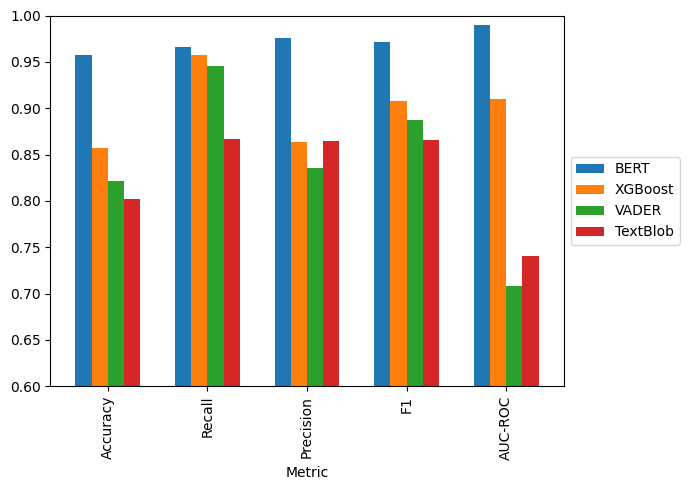

In [36]:
# plot metrics 

fig, ax= plt.subplots(1,1, figsize=(7,5))

pd.DataFrame(results_dict).T.plot.bar(ax = ax, width = 0.65)
ax.set_xlabel('Metric')
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

plt.ylim(0.6, 1)

fig.tight_layout()
fig.show()

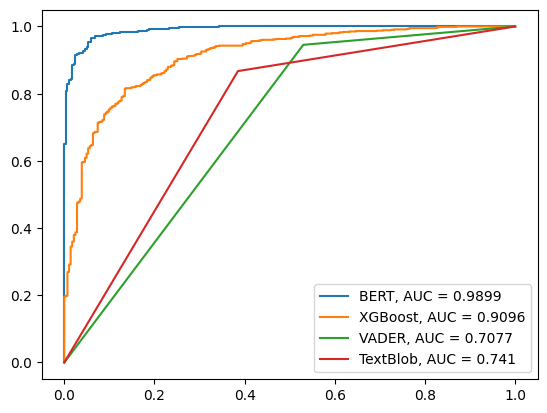

In [15]:
# plot auc curve

plt.figure(0).clf()

pred_probas = [y_pred_bert_score, y_pred_xgb_score, vader, textblob]
models = ['BERT', 'XGBoost', 'VADER', 'TextBlob']

for i in range(len(pred_probas)):
    fpr, tpr, _ = roc_curve(y_test, pred_probas[i])
    auc = round(roc_auc_score(y_test, pred_probas[i]), 4)
    plt.plot(fpr, tpr, label= models[i] + ", AUC = " + str(auc))

plt.legend()

In [16]:
# compare models and print best model
model_comparison(results_dict)

BERT performed the best among all the models.
{'BERT': 0, 'XGBoost': 6, 'VADER': 12, 'TextBlob': 12}


BERT outperformed all other models in accuracy, precision, recall, F1 and AUC-ROC. Furthermore, the AUC plot shows how BERT does a better job of clearly distinguishing between positive and negative sentiments. The model_comparison function ranks the models for each metric (0 = best, 4 = worst) and sums up their ranks across metrics. Based on this comparison, BERT shows to have the best performance across metrics and models.

# Predict on unseen data

Using BERT as the best model selected from the above comparison, this scoring functions takes in the input file 'revies_test.csv' with columns 'Text' and 'Time' and generates the predicted sentiment probabilities and labels. The output file is 'reviews_test_predictions_Group_9.csv' with 4 columns: 
* Text
* Time
* predicted_sentiment_probability
* predicted_sentiment.

Trained model of bert is saved in '../models/bert-full-train'.

In [ ]:
# train bert on full data
#train_bert(X, y, model_path = '../models/bert-full-train', use_mps = True)

In [ ]:
# predict and output predictions
final_df = pred_bert_new(filename = 'reviews_test.csv', col_name = 'Text', model_path = '../models/bert-full-train', use_mps = True)

In [ ]:
final_df.head()